In [17]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.cm as cm 

# Load all datasets from both customers and gateway
all_datasets = {}

# Load customers unified data
customers_root = Path("customers/unified")
for csv_file in customers_root.rglob("all_metrics_combined*.csv"):
    experiment_name = csv_file.parent.name 
    df = pd.read_csv(csv_file)
    df["source"] = experiment_name.upper()
    df["service"] = "customers"
    all_datasets[f"customers_{experiment_name}"] = df
    print(f"Loaded customers {experiment_name} experiment ({len(df)} rows)")

# Load customers jvm unified data  
customers_jvm_root = Path("customers jvm/unified")
for csv_file in customers_jvm_root.rglob("all_metrics_combined*.csv"):
    experiment_name = csv_file.parent.name 
    df = pd.read_csv(csv_file)
    df["source"] = experiment_name.upper()
    df["service"] = "customers"
    all_datasets[f"customers_{experiment_name}"] = df
    print(f"Loaded customers jvm {experiment_name} experiment ({len(df)} rows)")

# Load gateway unified data  
gateway_root = Path("gateway/unified")
for csv_file in gateway_root.rglob("all_metrics_combined*.csv"):
    experiment_name = csv_file.parent.name 
    df = pd.read_csv(csv_file)
    df["source"] = experiment_name.upper()
    df["service"] = "gateway"
    all_datasets[f"gateway_{experiment_name}"] = df
    print(f"Loaded gateway {experiment_name} experiment ({len(df)} rows)")

# Load gateway jvm unified data  
gateway_jvm_root = Path("gateway jvm/unified")
for csv_file in gateway_jvm_root.rglob("all_metrics_combined*.csv"):
    experiment_name = csv_file.parent.name 
    df = pd.read_csv(csv_file)
    df["source"] = experiment_name.upper()
    df["service"] = "gateway"
    all_datasets[f"gateway_{experiment_name}"] = df
    print(f"Loaded gateway jvm {experiment_name} experiment ({len(df)} rows)")

df_all = pd.concat(all_datasets.values(), ignore_index=True)

print(f"\nTotal datasets loaded: {len(all_datasets)}")
print(f"Available datasets: {list(all_datasets.keys())}")
print(f"Combined dataframe: {len(df_all)} rows")


Loaded customers net_loss experiment (485 rows)
Loaded customers IOpressure experiment (481 rows)
Loaded customers mem_stress experiment (484 rows)
Loaded customers baseline experiment (492 rows)
Loaded customers cpu_stress experiment (484 rows)
Loaded customers jvm cache_filling experiment (480 rows)
Loaded customers jvm oom experiment (481 rows)
Loaded customers jvm threadfull experiment (481 rows)
Loaded customers jvm gc_stress experiment (481 rows)
Loaded customers jvm baseline experiment (486 rows)
Loaded gateway net_loss experiment (489 rows)
Loaded gateway mem_stress experiment (499 rows)
Loaded gateway delay experiment (491 rows)
Loaded gateway baseline experiment (492 rows)
Loaded gateway cpu_stress experiment (484 rows)
Loaded gateway jvm cache_filling experiment (481 rows)
Loaded gateway jvm oom experiment (481 rows)
Loaded gateway jvm threadfull experiment (478 rows)
Loaded gateway jvm gc_stress experiment (479 rows)
Loaded gateway jvm baseline experiment (486 rows)

Total 

## NaN cleaning and data processing

In [19]:
def custom_nan_cleaning(df, dataset_name):
    """
    Applica le strategie personalizzate per la pulizia dei NaN
    """
    print(f"\n{'='*60}")
    print(f"PULIZIA PERSONALIZZATA: {dataset_name}")
    print(f"{'='*60}")
    
    df_cleaned = df.copy()
    initial_nan_count = df_cleaned.isnull().sum().sum()
    
    # Lista delle metriche da sostituire con 0
    zero_fill_metrics = [
        'apigateway_api_gateway',
        'customersservice_customers_service',
        'visitsservice_visits_service',
        'vetsservice_vets_service'
    ]
    
    # 1. Sostituisci con 0 le metriche specificate
    print("\n🔧 Sostituendo NaN con 0 per metriche specifiche...")
    for metric in zero_fill_metrics:
        if metric in df_cleaned.columns:
            nan_count = df_cleaned[metric].isnull().sum()
            if nan_count > 0:
                df_cleaned[metric] = df_cleaned[metric].fillna(0)
                print(f"   ✓ '{metric}': {nan_count} NaN → 0")
        else:
            print(f"   ⚠️ Metrica '{metric}' non trovata nel dataset")
    
    # 2. Sostituisci blocklatency_disk sda con mediana
    print("\n🔧 Sostituendo NaN con mediana per blocklatency_disk sda...")
    blocklatency_col = 'blocklatency_disk sda'
    if blocklatency_col in df_cleaned.columns:
        nan_count = df_cleaned[blocklatency_col].isnull().sum()
        if nan_count > 0:
            median_val = df_cleaned[blocklatency_col].median()
            df_cleaned[blocklatency_col] = df_cleaned[blocklatency_col].fillna(median_val)
            print(f"   ✓ '{blocklatency_col}': {nan_count} NaN → mediana ({median_val:.4f})")
        else:
            print(f"   ✓ '{blocklatency_col}': nessun NaN trovato")
    else:
        print(f"   ⚠️ Colonna '{blocklatency_col}' non trovata nel dataset")
    
    # 3. Trasforma la colonna 'minutes' in counter temporale
    print("\n🔧 Trasformando colonna 'minutes' in counter temporale...")
    if 'minutes' in df_cleaned.columns:
        row_count = len(df_cleaned)
        # Crea un counter che parte da 0 e aumenta di 0.25 ogni riga (15 secondi = 0.25 minuti)
        time_counter = np.arange(0, row_count * 0.25, 0.25)[:row_count]
        df_cleaned['minutes'] = time_counter
        print(f"   ✓ 'minutes': sostituita con counter temporale da 0 a {time_counter[-1]:.2f} (step 0.25)")
    else:
        print(f"   ⚠️ Colonna 'minutes' non trovata nel dataset")
    
    # 4. Interpolazione per tutti i rimanenti NaN
    print("\n🔧 Applicando interpolazione lineare per NaN rimanenti...")
    
    # Identifica le colonne numeriche con NaN rimanenti
    numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns
    remaining_nan_cols = []
    
    for col in numeric_columns:
        if df_cleaned[col].isnull().sum() > 0:
            remaining_nan_cols.append(col)
    
    if remaining_nan_cols:
        print(f"   📊 Colonne con NaN da interpolare: {len(remaining_nan_cols)}")
        
        for col in remaining_nan_cols:
            nan_count_before = df_cleaned[col].isnull().sum()
            
            # Applica interpolazione lineare
            df_cleaned[col] = df_cleaned[col].interpolate(method='linear')
            
            # Se ci sono ancora NaN all'inizio o alla fine, usa forward/backward fill
            df_cleaned[col] = df_cleaned[col].fillna(method='bfill')  # backward fill per l'inizio
            df_cleaned[col] = df_cleaned[col].fillna(method='ffill')  # forward fill per la fine
            
            nan_count_after = df_cleaned[col].isnull().sum()
            print(f"     - '{col}': {nan_count_before} → {nan_count_after} NaN")
    else:
        print("   ✓ Nessun NaN rimanente nelle colonne numeriche")
    
    # 5. Gestione colonne source - mantieni solo una colonna source unificata
    print("\n🔧 Consolidando colonne source...")
    
    # Identifica tutte le colonne che contengono 'source' nel nome
    source_columns = [col for col in df_cleaned.columns if 'source' in col.lower()]
    
    if len(source_columns) > 1:
        print(f"   📋 Trovate {len(source_columns)} colonne source: {source_columns}")
        
        # Prendi la prima colonna source non-null come riferimento
        main_source_col = None
        source_value = None
        
        for col in source_columns:
            non_null_values = df_cleaned[col].dropna().unique()
            if len(non_null_values) > 0:
                main_source_col = col
                source_value = non_null_values[0]
                break
        
        if main_source_col and source_value:
            # Mantieni solo la colonna 'source' e riempi con il valore trovato
            if 'source' not in df_cleaned.columns:
                df_cleaned['source'] = source_value
            else:
                df_cleaned['source'] = df_cleaned['source'].fillna(source_value)
            
            # Rimuovi tutte le altre colonne source
            cols_to_drop = [col for col in source_columns if col != 'source']
            if cols_to_drop:
                df_cleaned = df_cleaned.drop(columns=cols_to_drop)
                print(f"   ✓ Rimosse colonne: {cols_to_drop}")
                print(f"   ✓ Mantenuta colonna 'source' con valore: '{source_value}'")
        else:
            print(f"   ⚠️ Nessun valore valido trovato nelle colonne source")
    
    elif 'source' in df_cleaned.columns:
        # Se c'è solo la colonna 'source', riempi i NaN con il valore più comune
        source_value = df_cleaned['source'].mode().iloc[0] if not df_cleaned['source'].mode().empty else "UNKNOWN"
        nan_count = df_cleaned['source'].isnull().sum()
        if nan_count > 0:
            df_cleaned['source'] = df_cleaned['source'].fillna(source_value)
            print(f"   ✓ 'source': {nan_count} NaN → '{source_value}'")
        else:
            print(f"   ✓ 'source': nessun NaN trovato")

    # 6. Gestione colonne non-numeriche rimanenti
    print("\n🔧 Gestendo colonne non-numeriche con NaN...")
    non_numeric_columns = df_cleaned.select_dtypes(exclude=[np.number]).columns
    
    for col in non_numeric_columns:
        if col == 'source':  # Già gestita sopra
            continue
            
        nan_count = df_cleaned[col].isnull().sum()
        if nan_count > 0:
            if col in ['service']:
                # Per colonne identificative, rimuovi le righe
                print(f"   ⚠️ '{col}': {nan_count} NaN - considerare rimozione righe")
            else:
                # Per altre colonne testuali, usa "Unknown"
                df_cleaned[col] = df_cleaned[col].fillna("Unknown")
                print(f"   ✓ '{col}': {nan_count} NaN → 'Unknown'")
    
    # Statistiche finali
    final_nan_count = df_cleaned.isnull().sum().sum()
    
    print(f"\n📊 RISULTATI PULIZIA:")
    print(f"   • NaN iniziali: {initial_nan_count}")
    print(f"   • NaN finali: {final_nan_count}")
    print(f"   • NaN rimossi: {initial_nan_count - final_nan_count}")
    print(f"   • Righe: {len(df)} → {len(df_cleaned)}")
    print(f"   • Colonne: {len(df.columns)} → {len(df_cleaned.columns)}")
    
    if final_nan_count > 0:
        print(f"\n⚠️ NaN rimanenti per colonna:")
        remaining_nan = df_cleaned.isnull().sum()
        for col, count in remaining_nan[remaining_nan > 0].items():
            print(f"     - '{col}': {count} NaN")
    else:
        print(f"\n✅ Dataset completamente pulito!")
    
    return df_cleaned

def analyze_before_after_cleaning(df_original, df_cleaned, dataset_name):
    """
    Confronta il dataset prima e dopo la pulizia
    """
    print(f"\n{'='*60}")
    print(f"CONFRONTO PRIMA/DOPO: {dataset_name}")
    print(f"{'='*60}")
    
    print("\n📊 STATISTICHE GENERALI:")
    print(f"   Righe: {len(df_original)} → {len(df_cleaned)}")
    print(f"   Colonne: {len(df_original.columns)} → {len(df_cleaned.columns)}")
    print(f"   NaN totali: {df_original.isnull().sum().sum()} → {df_cleaned.isnull().sum().sum()}")
    
    # Analisi colonna minutes
    if 'minutes' in df_original.columns and 'minutes' in df_cleaned.columns:
        print(f"\n⏱️ TRASFORMAZIONE COLONNA 'minutes':")
        print(f"   Prima - Tipo: timestamp (es. 2025-05-17 17:01:15)")
        print(f"   Dopo - Tipo: {df_cleaned['minutes'].dtype}, "
              f"Range: {df_cleaned['minutes'].min():.2f} - {df_cleaned['minutes'].max():.2f}")
        if len(df_cleaned) > 1:
            print(f"   Step temporale: {df_cleaned['minutes'].iloc[1] - df_cleaned['minutes'].iloc[0]:.3f} minuti")
    
    return df_cleaned

# Applica la pulizia personalizzata a tutti i dataset
print("\n" + "="*80)
print("APPLICAZIONE PULIZIA PERSONALIZZATA A TUTTI I DATASET")
print("="*80)

cleaned_datasets = {}

for dataset_name, df in all_datasets.items():
    df_cleaned = custom_nan_cleaning(df, dataset_name)
    analyze_before_after_cleaning(df, df_cleaned, dataset_name)
    cleaned_datasets[dataset_name] = df_cleaned

# Crea il dataframe combinato pulito
df_all_cleaned = pd.concat(cleaned_datasets.values(), ignore_index=True)

print(f"\n{'='*80}")
print("RISULTATI FINALI")
print(f"{'='*80}")
print(f"✅ Tutti i {len(all_datasets)} dataset sono stati puliti!")
print(f"📊 Dataset combinato finale:")
print(f"   • Righe: {len(df_all)} → {len(df_all_cleaned)}")
print(f"   • Colonne: {len(df_all.columns)} → {len(df_all_cleaned.columns)}")
print(f"   • NaN totali: {df_all.isnull().sum().sum()} → {df_all_cleaned.isnull().sum().sum()}")

# Mostra un esempio della trasformazione della colonna minutes
if 'minutes' in df_all_cleaned.columns:
    print(f"\n⏱️ ESEMPIO TRASFORMAZIONE TEMPORALE:")
    sample_minutes = df_all_cleaned['minutes'].head(10).values
    print(f"   Prime 10 righe della colonna 'minutes': {sample_minutes}")
    print(f"   Incremento costante di 0.25 minuti (15 secondi) per riga")

# I tuoi dataset puliti sono ora disponibili in:
# - cleaned_datasets (dizionario con dataset singoli puliti)
# - df_all_cleaned (dataframe combinato pulito)


APPLICAZIONE PULIZIA PERSONALIZZATA A TUTTI I DATASET

PULIZIA PERSONALIZZATA: customers_net_loss

🔧 Sostituendo NaN con 0 per metriche specifiche...
   ✓ 'apigateway_api_gateway': 12 NaN → 0
   ✓ 'customersservice_customers_service': 12 NaN → 0
   ✓ 'visitsservice_visits_service': 245 NaN → 0
   ✓ 'vetsservice_vets_service': 273 NaN → 0

🔧 Sostituendo NaN con mediana per blocklatency_disk sda...
   ✓ 'blocklatency_disk sda': 2 NaN → mediana (13.0000)

🔧 Trasformando colonna 'minutes' in counter temporale...
   ✓ 'minutes': sostituita con counter temporale da 0 a 121.00 (step 0.25)

🔧 Applicando interpolazione lineare per NaN rimanenti...
   📊 Colonne con NaN da interpolare: 12
     - 'memavailable_mem_available': 4 → 0 NaN
     - 'memcache_mem_cache': 4 → 0 NaN
     - 'memutil_mem_util': 4 → 0 NaN
     - 'readbytes_openeuler-home': 2 → 0 NaN
     - 'readbytes_openeuler-root': 2 → 0 NaN
     - 'readbytes_openeuler-swap': 2 → 0 NaN
     - 'readbytes_sda': 2 → 0 NaN
     - 'srtt_SRTT_cu

/tmp/ipykernel_452255/3909900196.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[col] = df_cleaned[col].fillna(method='bfill')  # backward fill per l'inizio
/tmp/ipykernel_452255/3909900196.py:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[col] = df_cleaned[col].fillna(method='ffill')  # forward fill per la fine
/tmp/ipykernel_452255/3909900196.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[col] = df_cleaned[col].fillna(method='bfill')  # backward fill per l'inizio
/tmp/ipykernel_452255/3909900196.py:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[col] = df_cleaned[col].fillna(

     - 'writebytes_openeuler-home': 3 → 0 NaN
     - 'writebytes_openeuler-root': 3 → 0 NaN
     - 'writebytes_openeuler-swap': 3 → 0 NaN
     - 'writebytes_sda': 3 → 0 NaN

🔧 Consolidando colonne source...
   📋 Trovate 17 colonne source: ['apigateway_source', 'blocklatency_source', 'customersservice_source', 'iowait_source', 'irq_source', 'memavailable_source', 'memcache_source', 'memutil_source', 'readbytes_source', 'srtt_source', 'system_source', 'user_source', 'utilization_source', 'vetsservice_source', 'visitsservice_source', 'writebytes_source', 'source']
   ✓ Rimosse colonne: ['apigateway_source', 'blocklatency_source', 'customersservice_source', 'iowait_source', 'irq_source', 'memavailable_source', 'memcache_source', 'memutil_source', 'readbytes_source', 'srtt_source', 'system_source', 'user_source', 'utilization_source', 'vetsservice_source', 'visitsservice_source', 'writebytes_source']
   ✓ Mantenuta colonna 'source' con valore: 'NET_LOSS'

🔧 Gestendo colonne non-numeriche co

/tmp/ipykernel_452255/3909900196.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[col] = df_cleaned[col].fillna(method='bfill')  # backward fill per l'inizio
/tmp/ipykernel_452255/3909900196.py:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[col] = df_cleaned[col].fillna(method='ffill')  # forward fill per la fine
/tmp/ipykernel_452255/3909900196.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[col] = df_cleaned[col].fillna(method='bfill')  # backward fill per l'inizio
/tmp/ipykernel_452255/3909900196.py:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[col] = df_cleaned[col].fillna(

# NaN visual

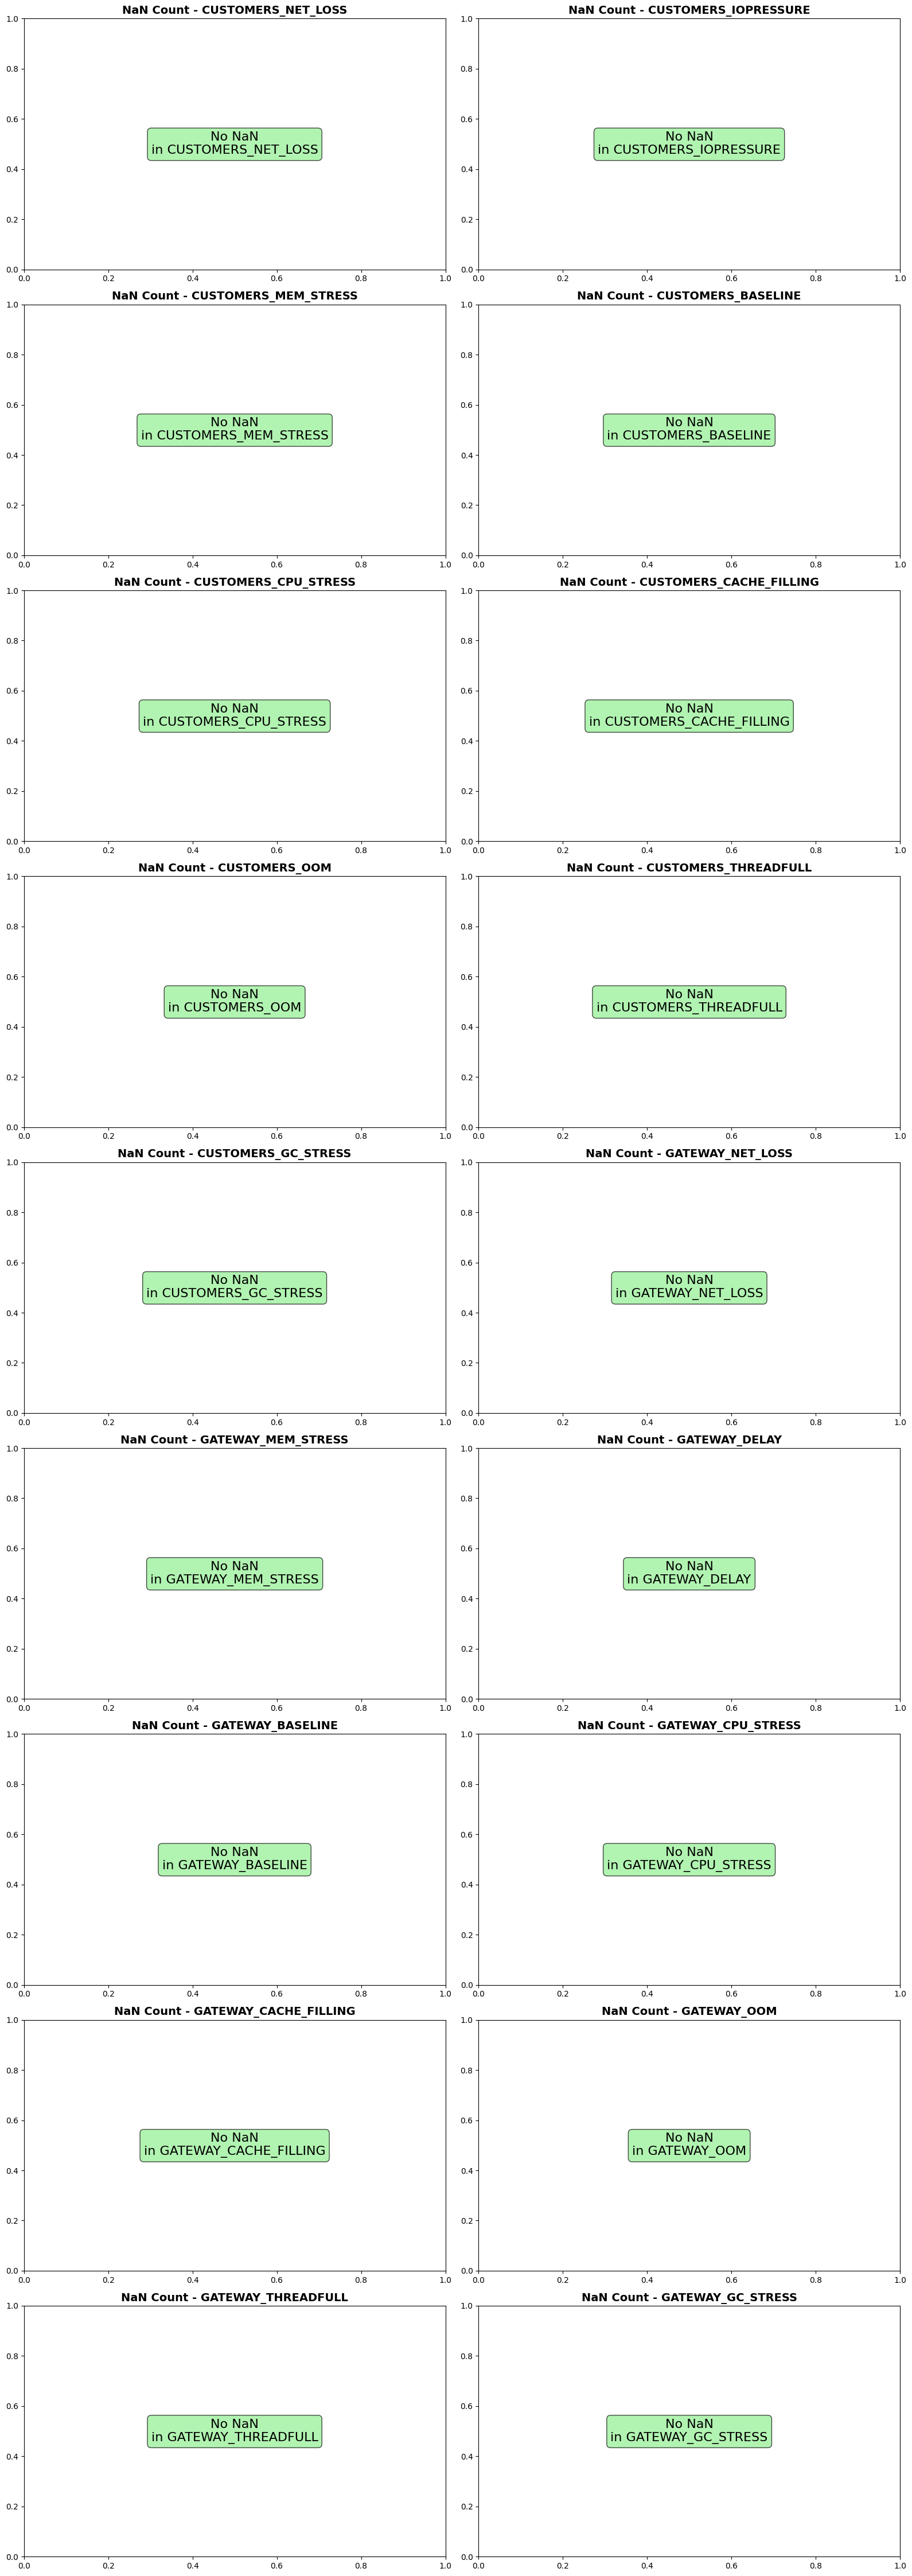


SUMMARY NaN PER ESPERIMENTO
CUSTOMERS_NET_LOSS:      0 NaN totali,   0 features con NaN
CUSTOMERS_IOPRESSURE:      0 NaN totali,   0 features con NaN
CUSTOMERS_MEM_STRESS:      0 NaN totali,   0 features con NaN
CUSTOMERS_BASELINE:      0 NaN totali,   0 features con NaN
CUSTOMERS_CPU_STRESS:      0 NaN totali,   0 features con NaN
CUSTOMERS_CACHE_FILLING:      0 NaN totali,   0 features con NaN
CUSTOMERS_OOM  :      0 NaN totali,   0 features con NaN
CUSTOMERS_THREADFULL:      0 NaN totali,   0 features con NaN
CUSTOMERS_GC_STRESS:      0 NaN totali,   0 features con NaN
GATEWAY_NET_LOSS:      0 NaN totali,   0 features con NaN
GATEWAY_MEM_STRESS:      0 NaN totali,   0 features con NaN
GATEWAY_DELAY  :      0 NaN totali,   0 features con NaN
GATEWAY_BASELINE:      0 NaN totali,   0 features con NaN
GATEWAY_CPU_STRESS:      0 NaN totali,   0 features con NaN
GATEWAY_CACHE_FILLING:      0 NaN totali,   0 features con NaN
GATEWAY_OOM    :      0 NaN totali,   0 features con NaN
GATEWAY

In [23]:
def plot_simple_nan_histogram(df, title="NaN Count Histogram"):

    nan_counts = df.isnull().sum()
    
    has_nan = nan_counts[nan_counts > 0]
    
    if len(has_nan) == 0:
        print("Nessun valore NaN trovato nel dataset")
        return
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(has_nan)), has_nan.values, color='red', alpha=0.7)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('NaN Count', fontsize=12)
    plt.xticks(range(len(has_nan)), has_nan.index, rotation=45, ha='right')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Stampa anche un summary
    print(f"Totale features con NaN: {len(has_nan)}")
    print(f"Totale NaN nel dataset: {has_nan.sum()}")

def plot_nan_distribution_histogram(df, title="NaN Distribution per Row"):
    """
    Plotta la distribuzione del numero di NaN per riga
    """
    # Calcola quanti NaN ci sono per ogni riga
    nan_per_row = df.isnull().sum(axis=1)
    
    plt.figure(figsize=(10, 6))
    
    # Istogramma vero e proprio
    plt.hist(nan_per_row, bins=30, color='purple', alpha=0.7, edgecolor='black')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Numero di NaN per riga', fontsize=12)
    plt.ylabel('Frequenza', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"Statistiche NaN per riga:")
    print(f"Media: {nan_per_row.mean():.2f}")
    print(f"Mediana: {nan_per_row.median():.2f}")
    print(f"Massimo: {nan_per_row.max()}")
    print(f"Righe senza NaN: {(nan_per_row == 0).sum()}")

def plot_nan_histogram_all_experiments(all_datasets):
    """
    Plotta l'istogramma dei NaN per tutti gli esperimenti
    """
    experiments = list(all_datasets.keys())
    n_experiments = len(experiments)
    
    # Calcola dimensioni griglia
    if n_experiments <= 4:
        rows, cols = 2, 2
        figsize = (16, 10)
    else:
        rows = int(np.ceil(n_experiments / 2))
        cols = 2
        figsize = (16, 5*rows)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Se c'è solo un subplot, converti in lista
    if n_experiments == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, exp_name in enumerate(experiments):
        if i < len(axes):
            ax = axes[i]
            df = all_datasets[exp_name]
            
            # Calcola NaN count
            nan_counts = df.isnull().sum()
            has_nan = nan_counts[nan_counts > 0]
            
            if len(has_nan) > 0:
                # Plot bar chart
                bars = ax.bar(range(len(has_nan)), has_nan.values, color='red', alpha=0.7)
                
                ax.set_title(f'NaN Count - {exp_name.upper()}', fontsize=14, fontweight='bold')
                ax.set_xlabel('Features', fontsize=10)
                ax.set_ylabel('NaN Count', fontsize=10)
                
                # Abbrevia i nomi delle features per leggibilità
                feature_names = []
                for name in has_nan.index:
                    if len(name) > 12:
                        # Prendi prime 12 caratteri
                        short_name = name[:12] + "..."
                    else:
                        short_name = name
                    feature_names.append(short_name)
                
                ax.set_xticks(range(len(has_nan)))
                ax.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=8)
                
                ax.grid(True, alpha=0.3)
                
                # Aggiungi valori sopra le barre se sono poche
                if len(has_nan) <= 8:
                    for bar, value in zip(bars, has_nan.values):
                        ax.text(bar.get_x() + bar.get_width()/2, 
                               bar.get_height() + max(has_nan.values)*0.01,
                               f'{int(value)}', ha='center', va='bottom', fontsize=8)
                
                # Summary testuale nell'angolo
                total_nan = has_nan.sum()
                ax.text(0.02, 0.98, f'Total NaN: {total_nan}', transform=ax.transAxes, 
                       fontsize=10, verticalalignment='top', 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
            else:
                # Nessun NaN trovato
                ax.text(0.5, 0.5, f'No NaN\nin {exp_name.upper()}', 
                       ha='center', va='center', transform=ax.transAxes, 
                       fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
                ax.set_title(f'NaN Count - {exp_name.upper()}', fontsize=14, fontweight='bold')
    
    # Nascondi subplot vuoti
    for j in range(len(experiments), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary generale
    print(f"\n{'='*60}")
    print("SUMMARY NaN PER ESPERIMENTO")
    print(f"{'='*60}")
    for exp_name, df in cleaned_datasets.items():
        nan_counts = df.isnull().sum()
        has_nan = nan_counts[nan_counts > 0]
        total_nan = has_nan.sum() if len(has_nan) > 0 else 0
        features_with_nan = len(has_nan)
        
        print(f"{exp_name.upper():<15}: {total_nan:>6} NaN totali, {features_with_nan:>3} features con NaN")

# Esempi di utilizzo:

# Tutti gli esperimenti in una dashboard
plot_nan_histogram_all_experiments(cleaned_datasets)


## re-plot

{'customers_net_loss':      minutes  apigateway_api_gateway  blocklatency_disk sda  \
0       0.00                     0.0                   12.0   
1       0.25                     0.0                   12.0   
2       0.50                     0.0                   13.0   
3       0.75                     0.0                   13.0   
4       1.00                     0.0                   13.0   
..       ...                     ...                    ...   
480   120.00                     0.0                   13.0   
481   120.25                     0.0                   13.0   
482   120.50                     0.0                   13.0   
483   120.75                     0.0                   13.0   
484   121.00                     0.0                   13.0   

     customersservice_customers_service  iowait_cpu 0  iowait_cpu 1  \
0                                   0.0            10             0   
1                                   0.0            10             0   
2      

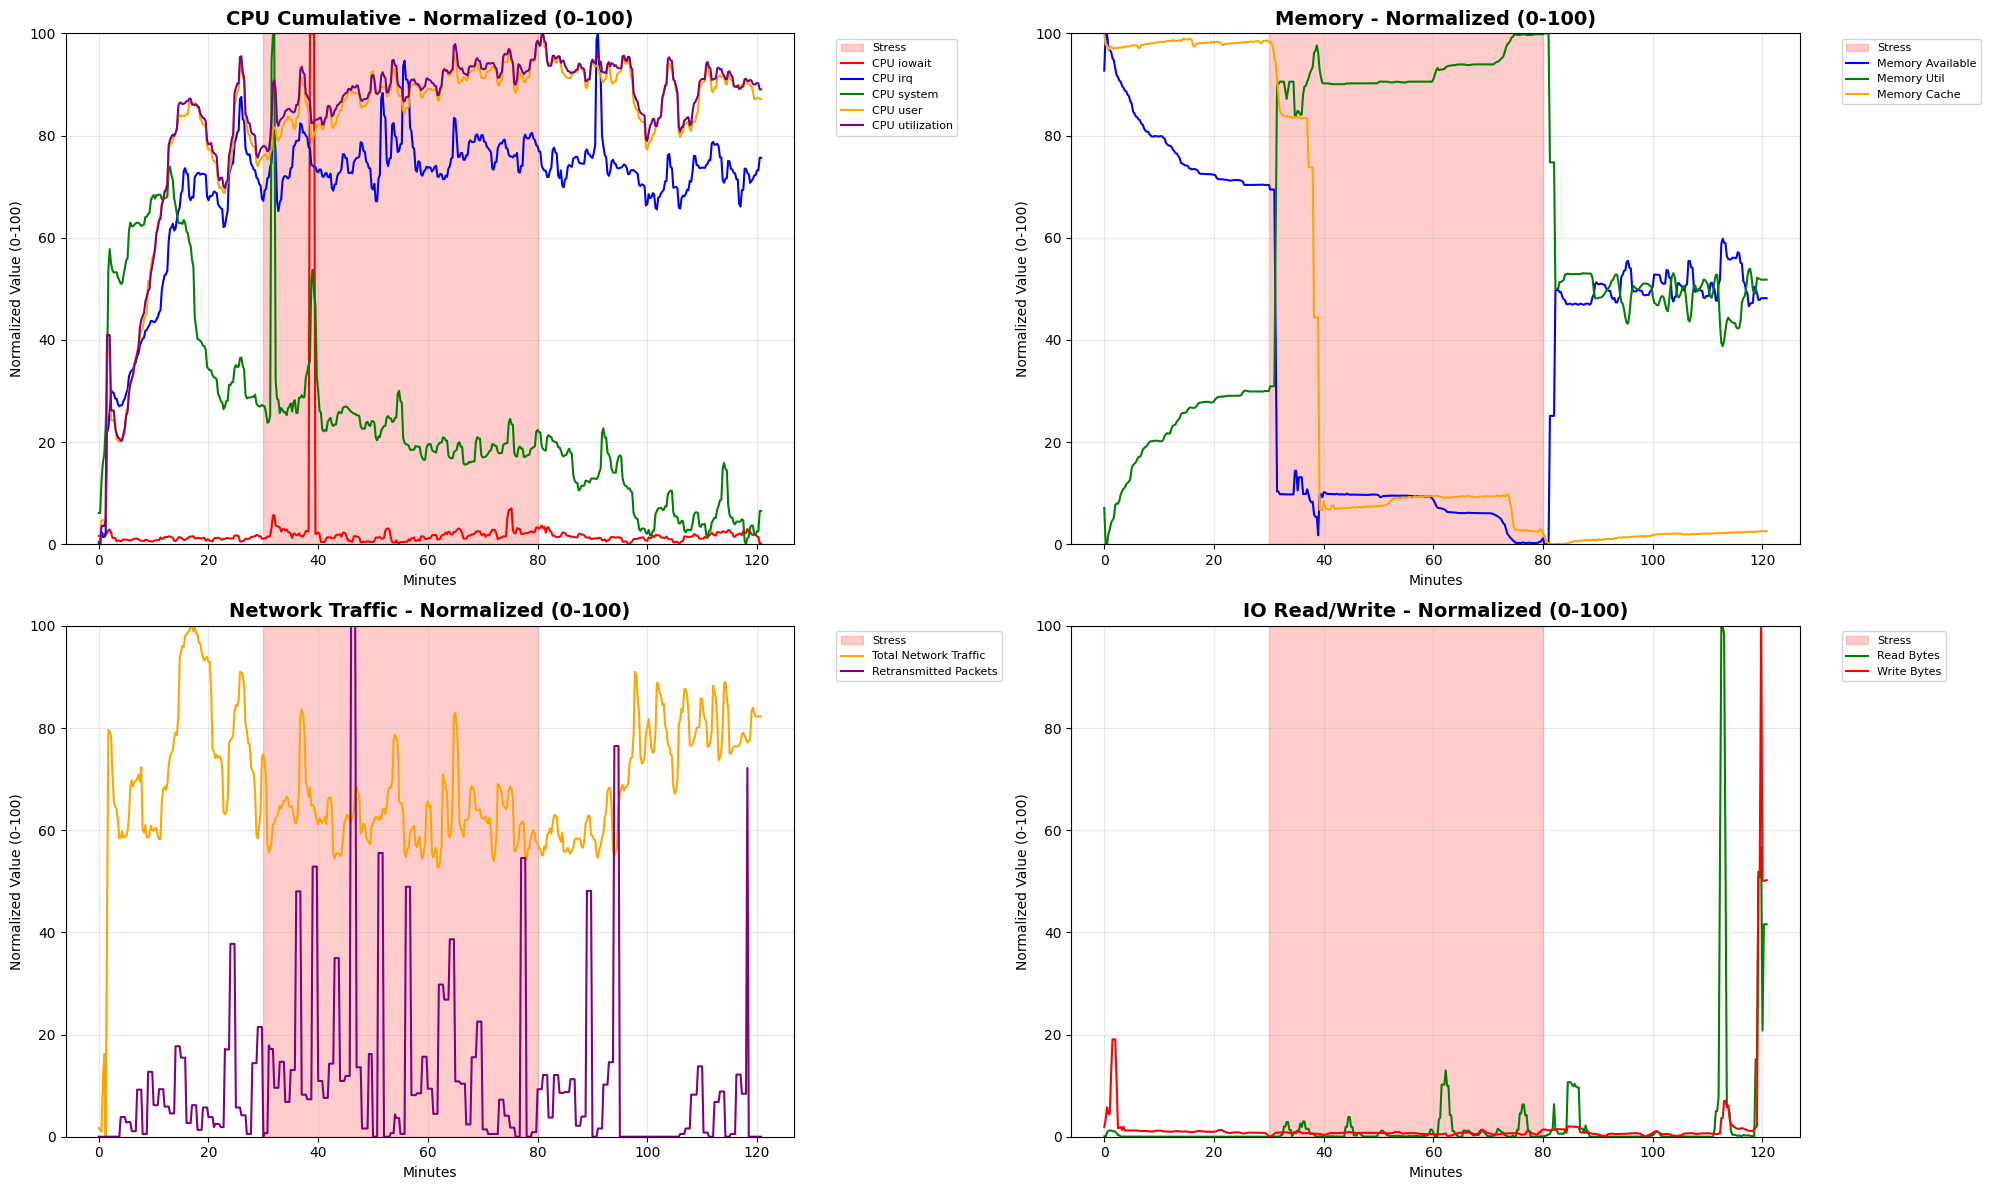

/tmp/ipykernel_452255/112254368.py:265: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')  # puoi anche usare 'Set2', 'Dark2', ecc.


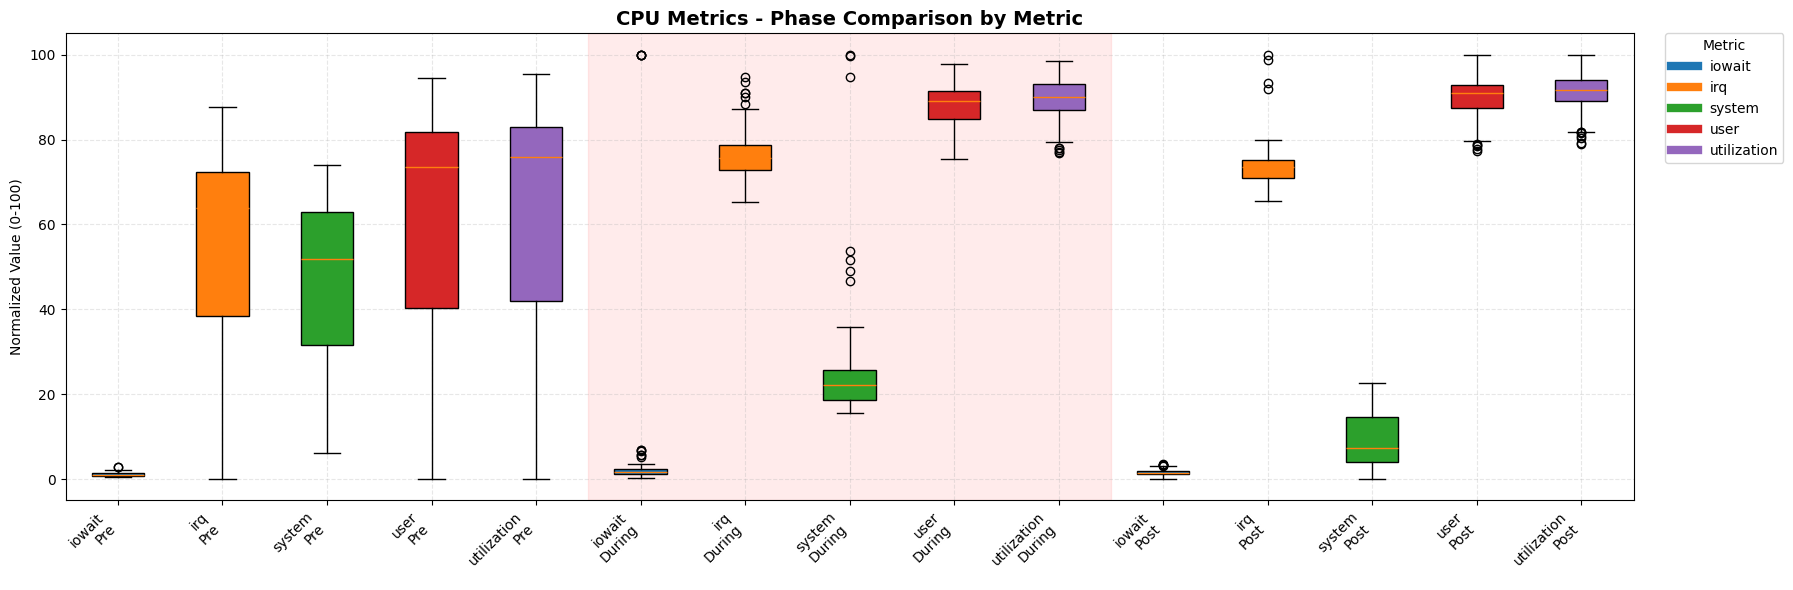

/tmp/ipykernel_452255/112254368.py:265: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')  # puoi anche usare 'Set2', 'Dark2', ecc.


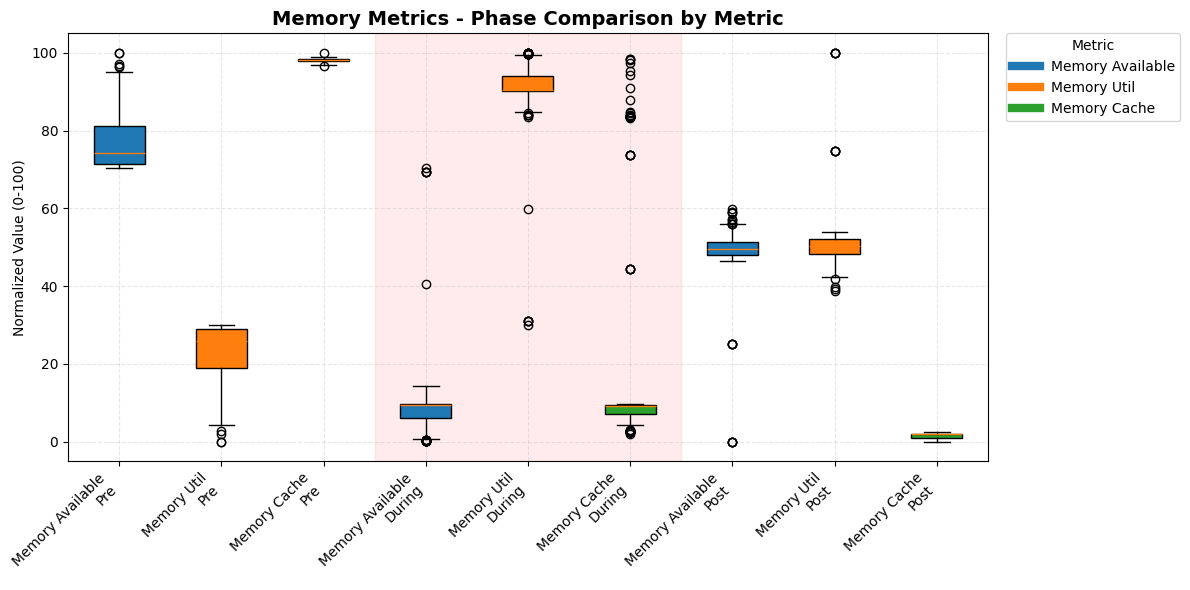

/tmp/ipykernel_452255/112254368.py:265: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')  # puoi anche usare 'Set2', 'Dark2', ecc.


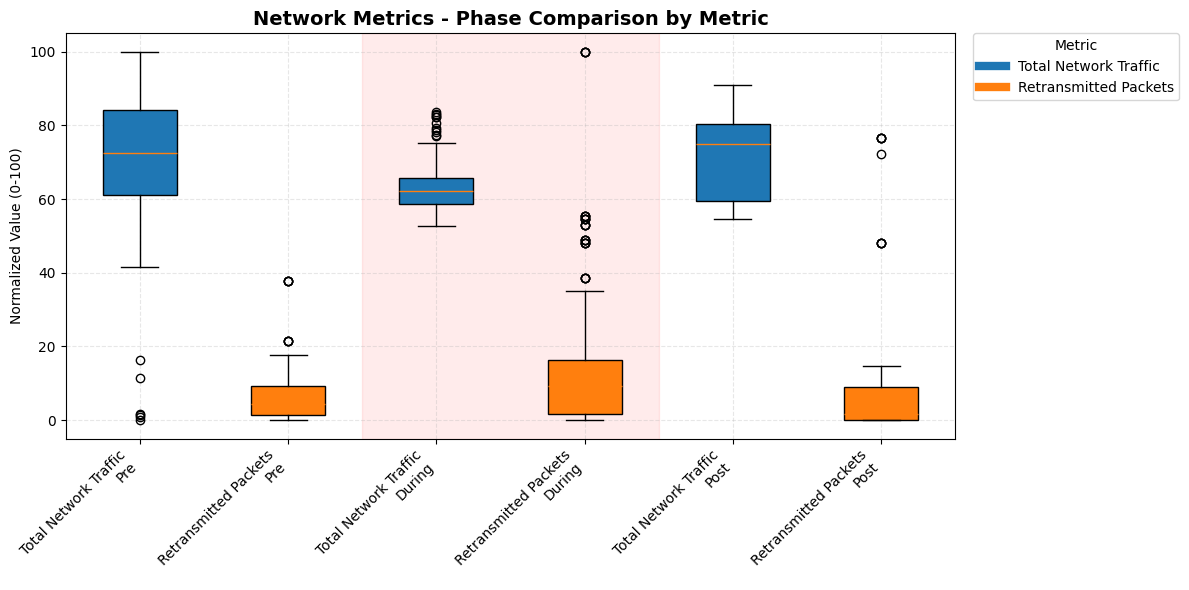

/tmp/ipykernel_452255/112254368.py:265: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')  # puoi anche usare 'Set2', 'Dark2', ecc.


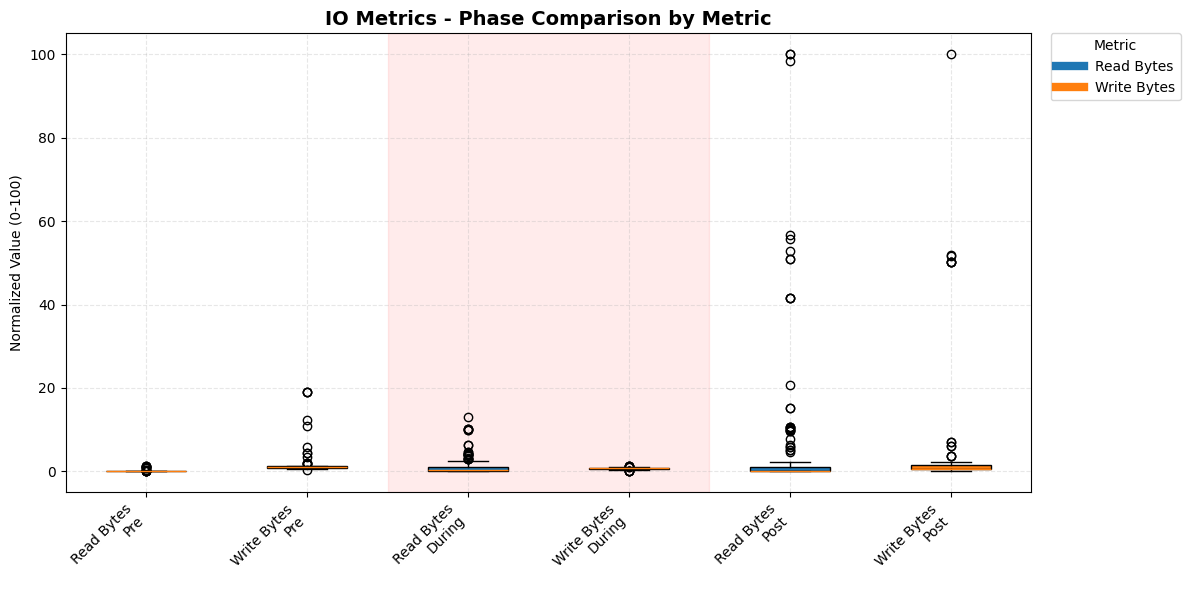

In [26]:
def normalize_0_100(series: pd.Series) -> pd.Series:
    min_val = series.min()
    max_val = series.max()
    if pd.isna(min_val) or pd.isna(max_val) or min_val == max_val:
        return pd.Series([0] * len(series), index=series.index)
    return (series - min_val) / (max_val - min_val) * 100

def process_series_for_plot(series: pd.Series, normalize: bool = True):
    if normalize:
        return normalize_0_100(series)
    else:
        return series

def calculate_cpu_cumulative(df: pd.DataFrame, metric_type: str):
    cpu_cols = [col for col in df.columns if metric_type.lower() in col.lower() 
                and 'cpu' in col.lower() and 'minutes' not in col.lower()]
    
    if not cpu_cols:
        return None
    
    # Filter only numeric columns
    numeric_cols = []
    for col in cpu_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
    
    if not numeric_cols:
        return None
    
    return df[numeric_cols].sum(axis=1)

def calculate_tcp_non_srtt_cumulative(df: pd.DataFrame):
    tcp_cols = []
    for col in df.columns:
        col_lower = col.lower()
        if any(tcp_term in col_lower for tcp_term in ['api', 'service', 'gateway', 'customer', 'vet', 'visit']) and 'srtt' not in col_lower and 'minutes' not in col_lower:
            tcp_cols.append(col)
    
    if not tcp_cols:
        return None
    
    # Filter only numeric columns
    numeric_cols = []
    for col in tcp_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
    
    if not numeric_cols:
        return None
    
    return df[numeric_cols].sum(axis=1)

def calculate_total_network_traffic(df: pd.DataFrame):
    srtt_cols = [col for col in df.columns if 'srtt' in col.lower() 
                 and 'minutes' not in col.lower()]
    
    if not srtt_cols:
        return None
    
    # Filter only numeric columns
    numeric_cols = []
    for col in srtt_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
    
    if not numeric_cols:
        return None
    
    return df[numeric_cols].sum(axis=1)

def safe_sum_numeric_cols(df: pd.DataFrame, cols: list):
    """Safely sum only numeric columns"""
    if not cols:
        return None
    
    numeric_cols = []
    for col in cols:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
    
    if not numeric_cols:
        return None
    
    return df[numeric_cols].sum(axis=1)

def plot_dashboard(df: pd.DataFrame, time_col='minutes', normalize=True):
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    title_suffix = "Normalized (0-100)" if normalize else "Original Values"
    ylabel = "Normalized Value (0-100)" if normalize else "Value"
    
    # CPU Plot
    ax1 = axes[0, 0]
    ax1.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    cpu_metrics = ['iowait', 'irq', 'system', 'user', 'utilization']
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for i, metric in enumerate(cpu_metrics):
        cumulative = calculate_cpu_cumulative(df, metric)
        if cumulative is not None:
            processed_series = process_series_for_plot(cumulative, normalize)
            ax1.plot(df[time_col], processed_series, 
                    label=f'CPU {metric}', 
                    linewidth=1.5,
                    color=colors[i % len(colors)])
    
    ax1.set_title(f"CPU Cumulative - {title_suffix}", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Minutes", fontsize=10)
    ax1.set_ylabel(ylabel, fontsize=10)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    if normalize:
        ax1.set_ylim(0, 100)
    
    # Memory Plot
    ax2 = axes[0, 1]
    ax2.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    mem_available = [col for col in df.columns if 'memavailable' in col.lower() 
                     and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    mem_util = [col for col in df.columns if 'memutil' in col.lower() 
                and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    mem_cache = [col for col in df.columns if 'memcache' in col.lower() 
                 and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    
    colors = ['blue', 'green', 'orange']
    labels = ['Memory Available', 'Memory Util', 'Memory Cache']
    metric_groups = [mem_available, mem_util, mem_cache]
    
    for i, (metrics, label, color) in enumerate(zip(metric_groups, labels, colors)):
        for col in metrics:
            if col in df.columns:
                processed_series = process_series_for_plot(df[col], normalize)
                ax2.plot(df[time_col], processed_series, 
                        label=label, 
                        linewidth=1.5,
                        color=color)
                break
    
    ax2.set_title(f"Memory - {title_suffix}", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Minutes", fontsize=10)
    ax2.set_ylabel(ylabel, fontsize=10)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)
    if normalize:
        ax2.set_ylim(0, 100)
    
    # Network Plot
    ax3 = axes[1, 0]
    ax3.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    total_network_traffic = calculate_total_network_traffic(df)
    retransmitted_packets = calculate_tcp_non_srtt_cumulative(df)
    
    if total_network_traffic is not None:
        processed_traffic = process_series_for_plot(total_network_traffic, normalize)
        ax3.plot(df[time_col], processed_traffic, 
                label='Total Network Traffic', 
                linewidth=1.5,
                color='orange')
    
    if retransmitted_packets is not None:
        processed_packets = process_series_for_plot(retransmitted_packets, normalize)
        ax3.plot(df[time_col], processed_packets, 
                label='Retransmitted Packets', 
                linewidth=1.5,
                color='purple')
    
    ax3.set_title(f"Network Traffic - {title_suffix}", fontsize=14, fontweight='bold')
    ax3.set_xlabel("Minutes", fontsize=10)
    ax3.set_ylabel(ylabel, fontsize=10)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)
    if normalize:
        ax3.set_ylim(0, 100)
    
    # IO Plot
    ax4 = axes[1, 1]
    ax4.axvspan(30, 80, alpha=0.2, color='red', label='Stress')
    
    read_cols = [col for col in df.columns if 'readbytes' in col.lower() 
                 and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    write_cols = [col for col in df.columns if 'writebytes' in col.lower() 
                  and 'minutes' not in col.lower() and pd.api.types.is_numeric_dtype(df[col])]
    
    read_cumulative = safe_sum_numeric_cols(df, read_cols)
    write_cumulative = safe_sum_numeric_cols(df, write_cols)
    
    if read_cumulative is not None:
        processed_read = process_series_for_plot(read_cumulative, normalize)
        ax4.plot(df[time_col], processed_read, 
                label='Read Bytes', 
                linewidth=1.5,
                color='green')
    
    if write_cumulative is not None:
        processed_write = process_series_for_plot(write_cumulative, normalize)
        ax4.plot(df[time_col], processed_write, 
                label='Write Bytes', 
                linewidth=1.5,
                color='red')
    
    ax4.set_title(f"IO Read/Write - {title_suffix}", fontsize=14, fontweight='bold')
    ax4.set_xlabel("Minutes", fontsize=10)
    ax4.set_ylabel(ylabel, fontsize=10)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)
    if normalize:
        ax4.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()
print(cleaned_datasets)

def plot_boxplot(df: pd.DataFrame, area: str, time_col='minutes', normalize=True):
    assert area in ['cpu', 'memory', 'network', 'io'], "Area must be one of: 'cpu', 'memory', 'network', 'io'"
    
    if area == 'cpu':
        metrics = ['iowait', 'irq', 'system', 'user', 'utilization']
        get_series = lambda metric: calculate_cpu_cumulative(df, metric)
        title = "CPU Metrics"
    
    elif area == 'memory':
        mem_cols = {
            'memavailable': 'Memory Available',
            'memutil': 'Memory Util',
            'memcache': 'Memory Cache'
        }
        metrics = list(mem_cols.keys())
        labels_map = mem_cols
        get_series = lambda metric: df[[col for col in df.columns if metric in col.lower() and pd.api.types.is_numeric_dtype(df[col])]].iloc[:, 0]
        title = "Memory Metrics"
    
    elif area == 'network':
        metrics = ['total_traffic', 'retransmitted']
        labels_map = {
            'total_traffic': 'Total Network Traffic',
            'retransmitted': 'Retransmitted Packets'
        }
        get_series = lambda metric: calculate_total_network_traffic(df) if metric == 'total_traffic' else calculate_tcp_non_srtt_cumulative(df)
        title = "Network Metrics"
    
    elif area == 'io':
        metrics = ['read', 'write']
        labels_map = {
            'read': 'Read Bytes',
            'write': 'Write Bytes'
        }
        get_series = lambda metric: (
            safe_sum_numeric_cols(df, [col for col in df.columns if 'readbytes' in col.lower()])
            if metric == 'read'
            else safe_sum_numeric_cols(df, [col for col in df.columns if 'writebytes' in col.lower()])
        )
        title = "IO Metrics"

    # Maschere temporali
    phase_masks = {
        'Pre': df[time_col] < 30,
        'During': (df[time_col] >= 30) & (df[time_col] <= 80),
        'Post': df[time_col] > 80
    }

    # Colori distinti per ogni metrica
    cmap = cm.get_cmap('tab10')  # puoi anche usare 'Set2', 'Dark2', ecc.
    metric_colors = {metric: cmap(i % 10) for i, metric in enumerate(metrics)}

    box_data = []
    xtick_labels = []
    box_colors = []

    for phase in ['Pre', 'During', 'Post']:
        mask = phase_masks[phase]
        for metric in metrics:
            series = get_series(metric)
            if series is None:
                continue
            if normalize:
                series = normalize_0_100(series)
            values = series[mask].dropna()
            if values.empty:
                continue
            box_data.append(values)
            label = labels_map[metric] if 'labels_map' in locals() else metric
            xtick_labels.append(f"{label}\n{phase}")
            box_colors.append(metric_colors[metric])

    # Plot
    plt.figure(figsize=(max(12, len(box_data)*1.2), 6))
    bplots = plt.boxplot(box_data, patch_artist=True)

    for i, patch in enumerate(bplots['boxes']):
        patch.set_facecolor(box_colors[i])
        patch.set_edgecolor('black')

    # Etichette asse X
    plt.xticks(ticks=range(1, len(xtick_labels) + 1), labels=xtick_labels, rotation=45, ha='right')

    # Zona stress evidenziata
    num_metrics = len(metrics)
    plt.axvspan(num_metrics + 0.5, 2 * num_metrics + 0.5, alpha=0.08, color='red', label='Stress Phase')

    plt.ylabel("Normalized Value (0-100)" if normalize else "Value")
    plt.title(f"{title} - Phase Comparison by Metric", fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.3)

    # Legenda dei colori per metrica
    legend_handles = [
        plt.Line2D([0], [0], color=metric_colors[metric], lw=6, label=labels_map[metric] if 'labels_map' in locals() else metric)
        for metric in metrics
    ]
    plt.legend(
    handles=legend_handles,
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    title='Metric'
)


    plt.tight_layout()
    plt.show()

EXPERIMENT = 'customers_mem_stress'
experiments = ['cpu', 'memory', 'network', 'io']

plot_dashboard(cleaned_datasets[EXPERIMENT], normalize=True)

for area in experiments:
    plot_boxplot(cleaned_datasets[EXPERIMENT], area)

In [7]:
def add_failure_feature(df, time_col='minutes'):
    """Add failure feature based on time window (30-80 minutes)"""
    df = df.copy()
    
    if time_col not in df.columns:
        raise ValueError(f"Time column '{time_col}' not found")
    
    df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
    df['Failure'] = 0
    df.loc[(df[time_col] >= 30) & (df[time_col] < 80), 'Failure'] = 1
    
    return df

def add_failure_to_all_datasets(all_datasets):
    """Add failure labels to all datasets permanently"""
    updated_datasets = {}
    
    for name, df in all_datasets.items():
        df_copy = df.copy()
        
        if 'baseline' in name.lower():
            df_copy['Failure'] = 0
        else:
            df_copy = add_failure_feature(df_copy)
        
        updated_datasets[name] = df_copy
    
    return updated_datasets

all_datasets = add_failure_to_all_datasets(all_datasets)

df_all_copy = df_all.copy()
df_all_copy['Failure'] = 0

# For non-baseline experiments, add failure based on time
non_baseline_mask = ~df_all_copy['source'].str.contains('BASELINE', case=False, na=False)
time_mask = (df_all_copy['minutes'] >= 30) & (df_all_copy['minutes'] < 80)
failure_mask = non_baseline_mask & time_mask

df_all_copy.loc[failure_mask, 'Failure'] = 1

# Update df_all permanently
df_all = df_all_copy

print("Failure feature added permanently to all datasets")
print(f"Individual datasets with Failure column: {[name for name in all_datasets.keys() if 'Failure' in all_datasets[name].columns]}")
print(f"df_all has Failure column: {'Failure' in df_all.columns}")
print(f"df_all failure distribution: {df_all['Failure'].value_counts().to_dict()}")

# Now run the correlation analysis with permanently added Failure column
def analyze_all_datasets_with_failure(all_datasets, target_col='Failure', top_n=15):
    all_correlations = {}
    
    for dataset_name, df in all_datasets.items():
        # No need to add Failure column - it's already there permanently
        corr_df = failure_correlations(df, target_col)
        if corr_df is not None:
            all_correlations[dataset_name] = corr_df
            plot_failure_correlations(df, target_col, top_n, dataset_name)
    
    return all_correlations

def run_failure_analysis_permanent(all_datasets):
    """Run failure analysis with permanently added Failure columns"""
    # Exclude baseline from analysis
    datasets_to_analyze = {k: v for k, v in all_datasets.items() if 'baseline' not in k.lower()}
    
    all_correlations = analyze_all_datasets_with_failure(datasets_to_analyze)
    comparison_heatmap = plot_correlation_heatmap(all_correlations, top_features=None)  
    return all_correlations, comparison_heatmap

# Run the analysis with permanent Failure columns
all_correlations, heatmap = run_failure_analysis_permanent(all_datasets)

# Analyze constant features
constant_analysis = analyze_constant_features_in_correlations(all_correlations)

TypeError: '>=' not supported between instances of 'str' and 'int'

## heatmap per experiment

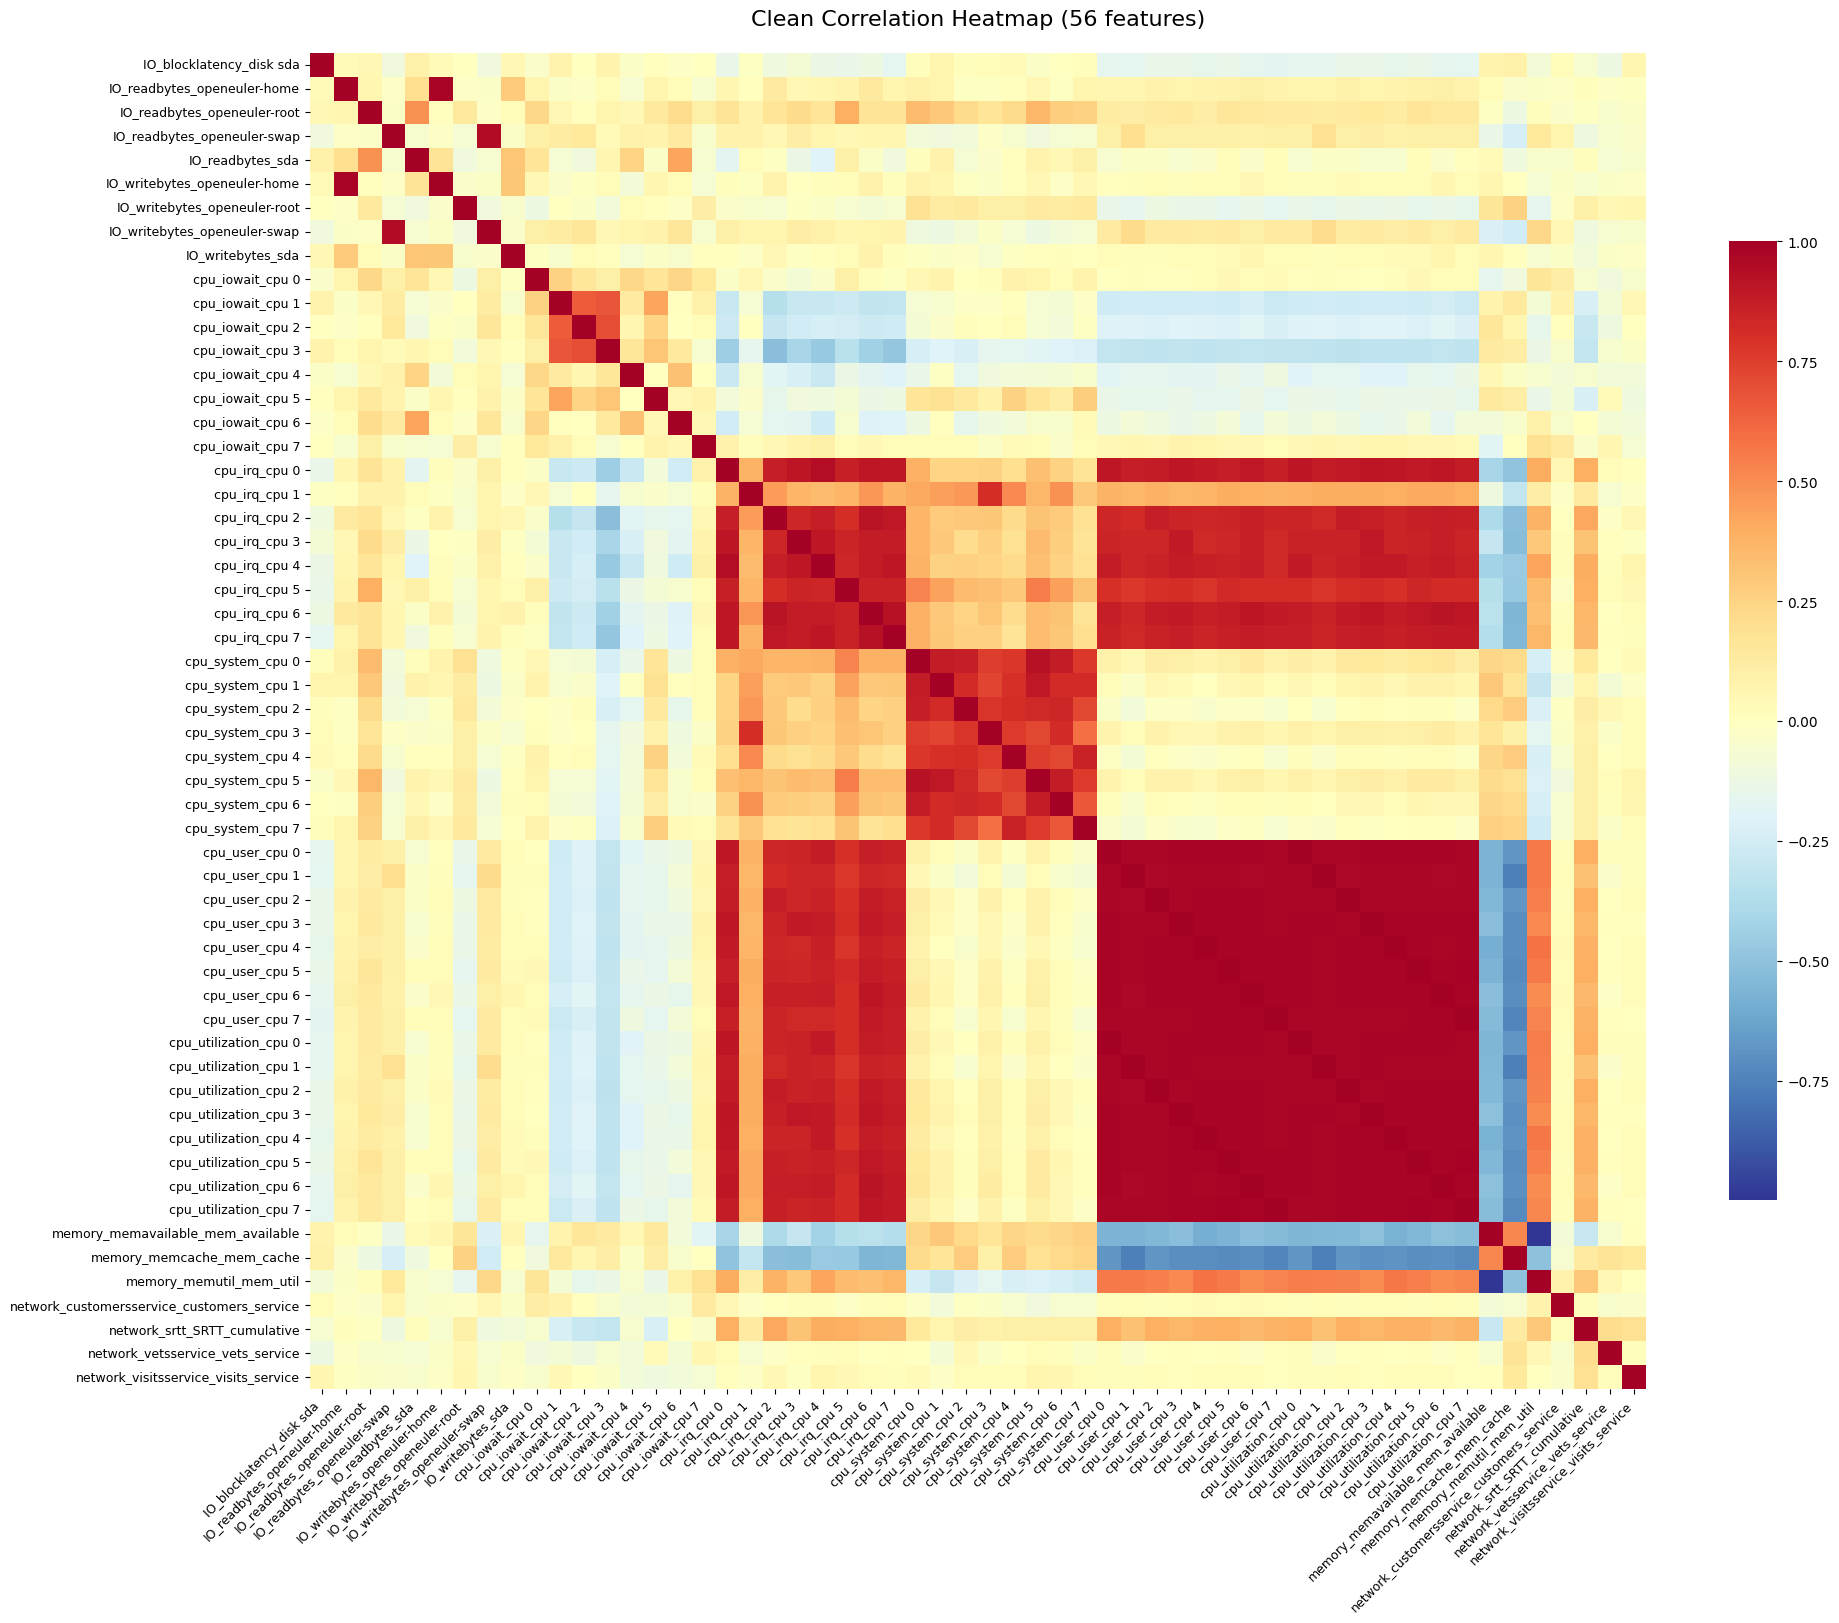

,IO_blocklatency_disk sda,IO_readbytes_openeuler-home,IO_readbytes_openeuler-root,IO_readbytes_openeuler-swap,IO_readbytes_sda,IO_writebytes_openeuler-home,IO_writebytes_openeuler-root,IO_writebytes_openeuler-swap,IO_writebytes_sda,cpu_iowait_cpu 0,...,cpu_utilization_cpu 5,cpu_utilization_cpu 6,cpu_utilization_cpu 7,memory_memavailable_mem_available,memory_memcache_mem_cache,memory_memutil_mem_util,network_customersservice_customers_service,network_srtt_SRTT_cumulative,network_vetsservice_vets_service,network_visitsservice_visits_service
IO_blocklatency_disk sda,1.000000,0.033349,0.040511,-0.100004,0.093005,0.035297,-0.003911,-0.097818,0.040947,-0.034820,...,-0.146170,-0.160466,-0.170845,0.074644,0.086477,-0.078451,0.019186,-0.060587,-0.119276,0.057947
IO_readbytes_openeuler-home,0.033349,1.000000,0.061702,-0.018483,0.196309,0.979568,-0.021156,-0.024926,0.286561,0.070363,...,0.087862,0.109422,0.075745,0.024315,-0.033847,-0.027025,-0.021261,0.010922,-0.022523,-0.014451
IO_readbytes_openeuler-root,0.040511,0.061702,1.000000,-0.023376,0.485578,0.006340,0.138596,-0.019161,0.021197,0.230410,...,0.166526,0.140667,0.137048,-0.013549,-0.118091,0.009882,-0.038564,-0.007507,-0.039901,-0.025630
IO_readbytes_openeuler-swap,-0.100004,-0.018483,-0.023376,1.000000,-0.050101,-0.021587,-0.064504,0.952182,-0.025093,0.097127,...,0.101966,0.094490,0.107480,-0.138700,-0.235833,0.146136,0.068831,-0.110718,-0.049917,-0.032028
IO_readbytes_sda,0.093005,0.196309,0.485578,-0.050101,1.000000,0.173676,-0.098779,-0.058080,0.311475,0.165186,...,0.020646,-0.037311,0.004761,0.033157,-0.108266,-0.040864,-0.046394,0.015819,-0.067297,-0.043460
IO_writebytes_openeuler-home,0.035297,0.979568,0.006340,-0.021587,0.173676,1.000000,-0.035995,-0.029035,0.302840,0.046097,...,0.031129,0.055621,0.020257,0.059727,-0.001139,-0.062358,-0.023586,-0.052141,-0.025718,-0.016006
IO_writebytes_openeuler-root,-0.003911,-0.021156,0.138596,-0.064504,-0.098779,-0.035995,1.000000,-0.100760,-0.044081,-0.121687,...,-0.148667,-0.133670,-0.155297,0.160661,0.255924,-0.157323,-0.016912,0.095524,0.046351,0.059758
IO_writebytes_openeuler-swap,-0.097818,-0.024926,-0.019161,0.952182,-0.058080,-0.029035,-0.100760,1.000000,-0.034081,0.102815,...,0.126560,0.107411,0.126052,-0.223766,-0.257262,0.231136,0.054313,-0.102053,-0.061091,-0.042232
IO_writebytes_sda,0.040947,0.286561,0.021197,-0.025093,0.311475,0.302840,-0.044081,-0.034081,1.000000,-0.008011,...,0.031898,0.063665,0.029804,0.059426,0.007260,-0.062067,-0.030435,-0.089002,-0.027586,-0.016358
cpu_iowait_cpu 0,-0.034820,0.070363,0.230410,0.097127,0.165186,0.046097,-0.121687,0.102815,-0.008011,1.000000,...,0.040361,0.021355,0.028657,-0.159816,-0.097674,0.157445,0.112213,-0.051236,-0.096184,-0.045402


In [4]:
def heatmap(data, title="Clean Correlation Heatmap", show_labels=True):
    numeric_data = data.select_dtypes(include=[np.number])
    
    if 'minutes' in numeric_data.columns:
        numeric_data = numeric_data.drop(columns=['minutes'])
    
    cpu_8_9_cols = [col for col in numeric_data.columns if 'cpu_8' in col or 'cpu_9' in col or 'cpu 8' in col or 'cpu 9' in col]
    if cpu_8_9_cols:
        numeric_data = numeric_data.drop(columns=cpu_8_9_cols)
    
    zero_variance_cols = []
    for col in numeric_data.columns:
        if numeric_data[col].var() == 0 or numeric_data[col].sum() == 0:
            zero_variance_cols.append(col)
    
    if zero_variance_cols:
        numeric_data = numeric_data.drop(columns=zero_variance_cols)
    
    nan_threshold = len(numeric_data) * 0.5
    high_nan_cols = [col for col in numeric_data.columns if numeric_data[col].isnull().sum() > nan_threshold]
    
    if high_nan_cols:
        numeric_data = numeric_data.drop(columns=high_nan_cols)
    
    numeric_data = numeric_data.fillna(0)
    corr = numeric_data.corr()
    corr = corr.fillna(0)
    
    if show_labels:
        fig, ax = plt.subplots(figsize=(20, 18))
    else:
        fig, ax = plt.subplots(figsize=(16, 14))
    
    sns.heatmap(corr, 
                cmap='RdYlBu_r', 
                center=0,
                square=True,
                cbar_kws={"shrink": .6},
                xticklabels=show_labels,
                yticklabels=show_labels,
                ax=ax)
    
    ax.set_title(f'{title} ({len(corr)} features)', fontsize=16, pad=20)
    
    if show_labels:
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(rotation=0, fontsize=9)
        plt.subplots_adjust(bottom=0.2, left=0.2)
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    return corr

def labeled_heatmap(data):
    return heatmap(data, show_labels=True)

labeled_heatmap(all_datasets['gatewaymem_stress'])

Failure feature added permanently to all datasets
Individual datasets with Failure column: ['customersnet_loss', 'customersmem_stress', 'customersIO pressure', 'customersbaseline', 'customerscpu_stress', 'gatewaynet_loss', 'gatewaymem_stress', 'gatewaydelay', 'gatewaybaseline', 'gatewaycpu_stress']
df_all has Failure column: True
df_all failure distribution: {0: 3269, 1: 1614}


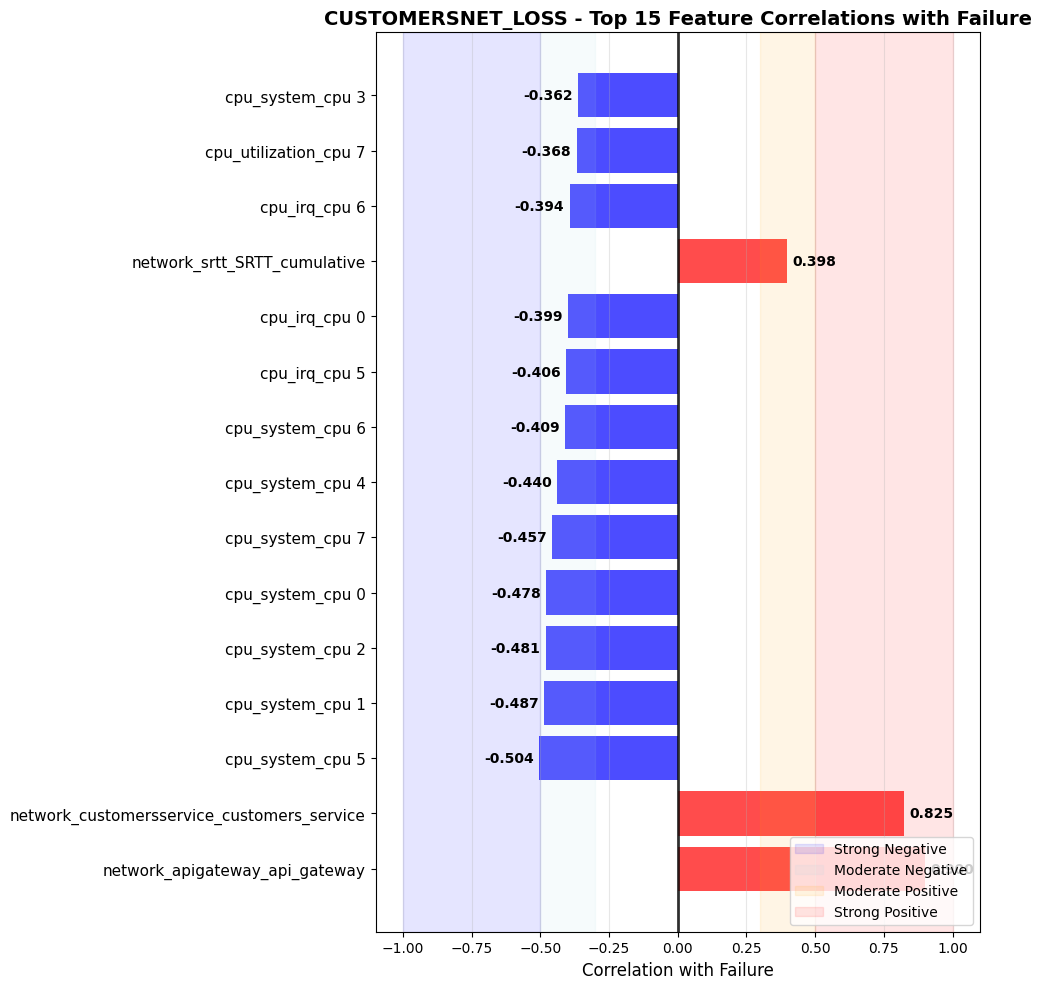

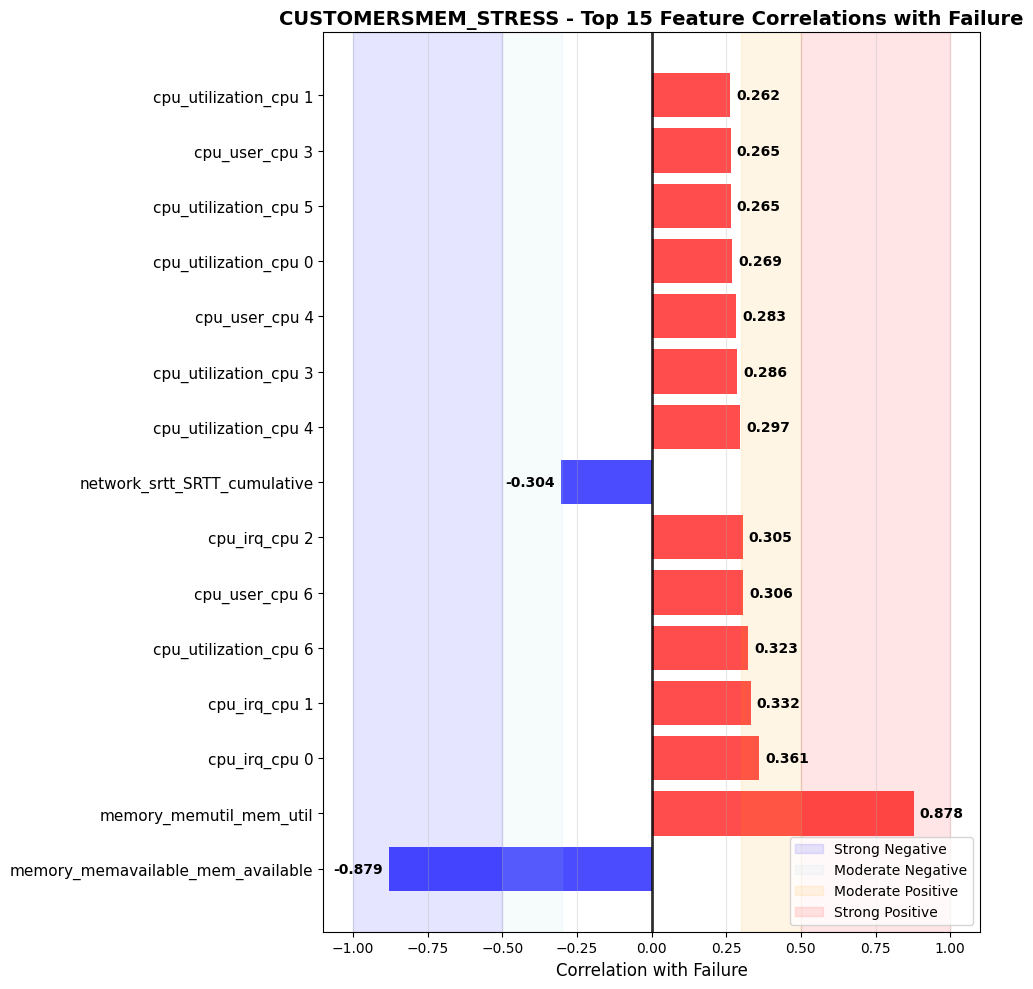

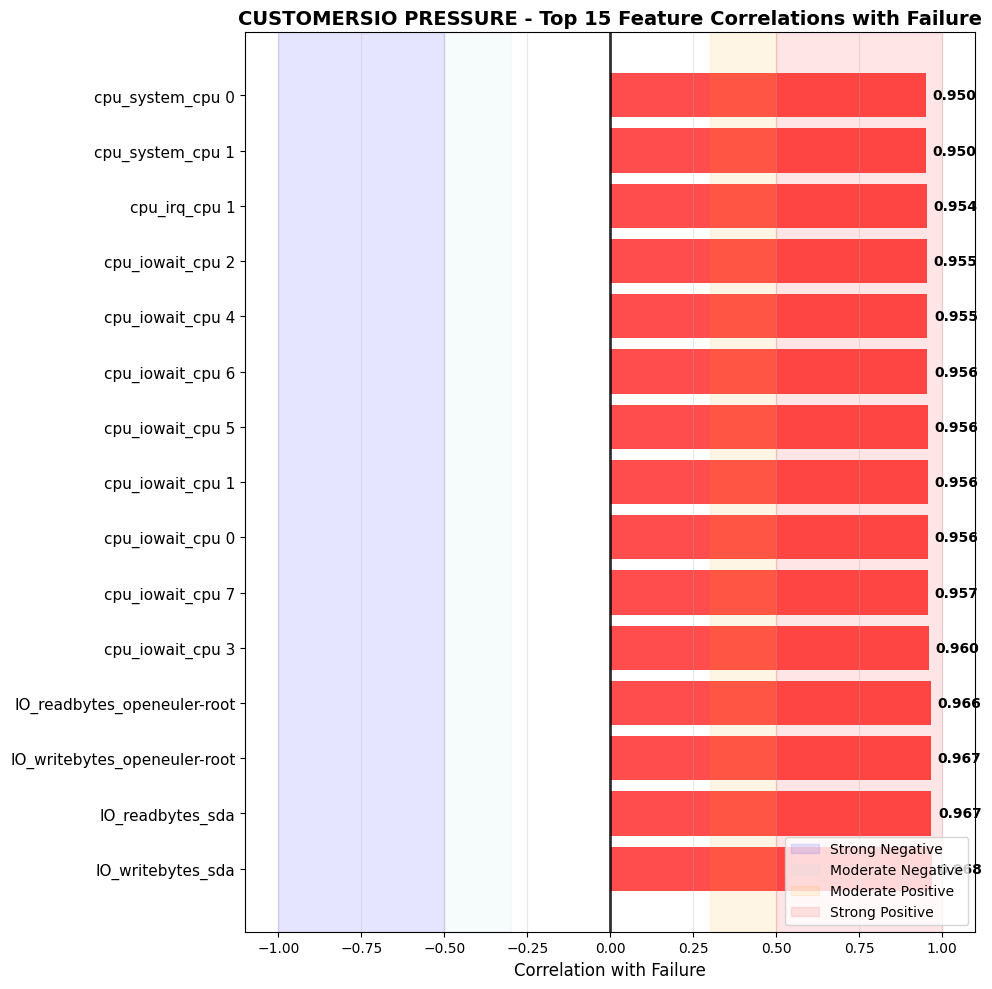

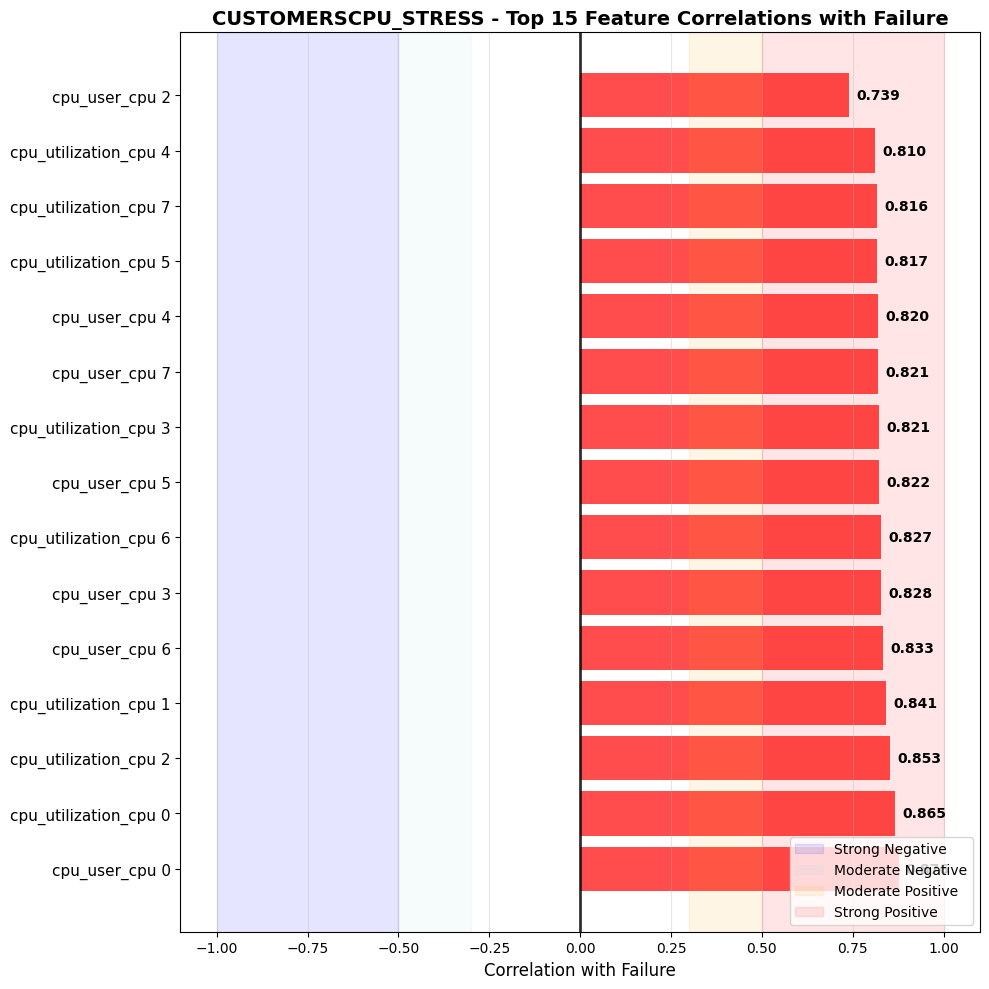

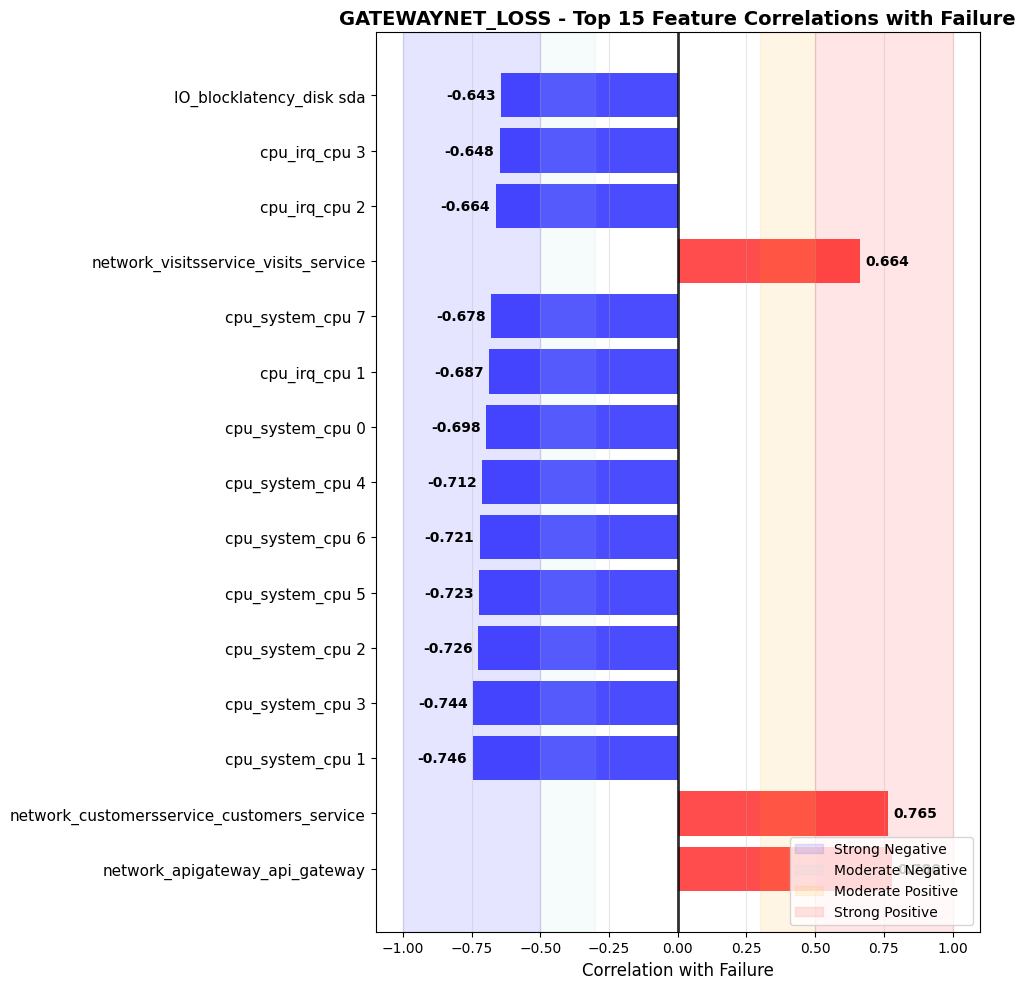

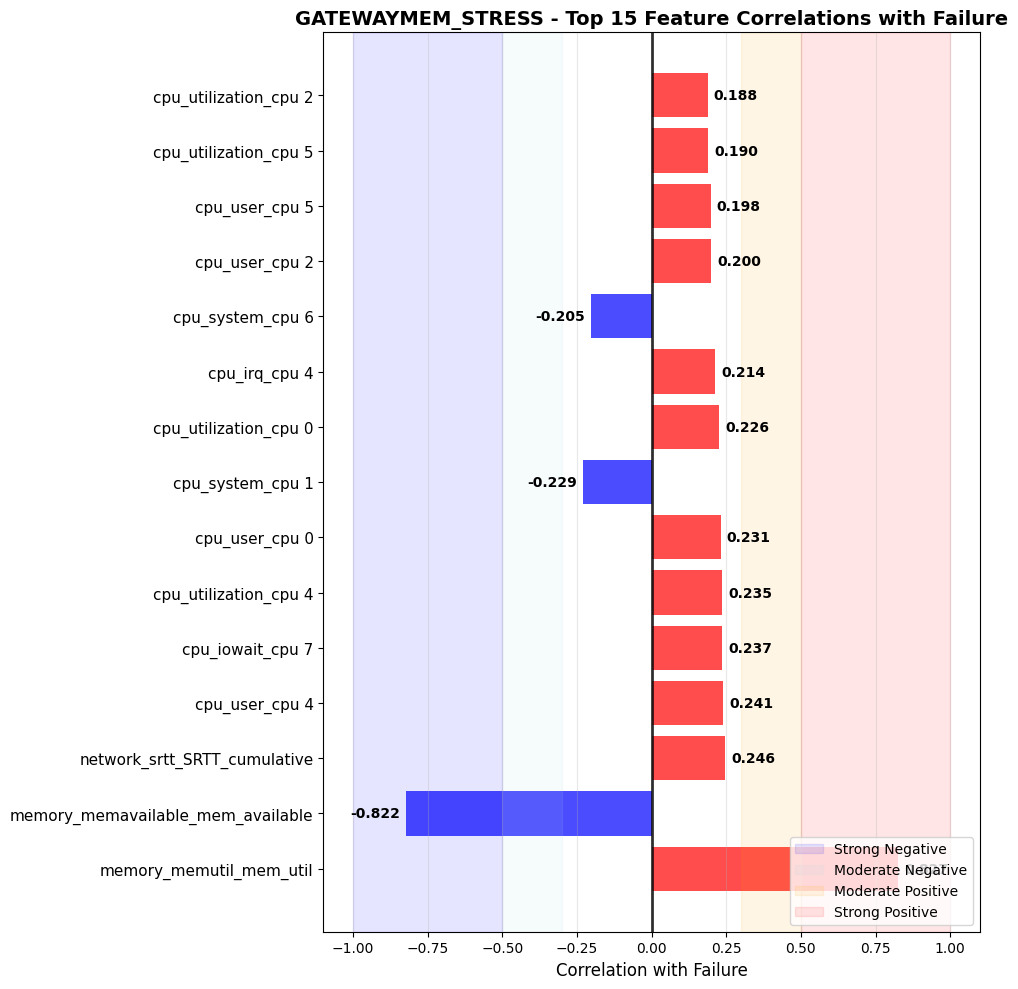

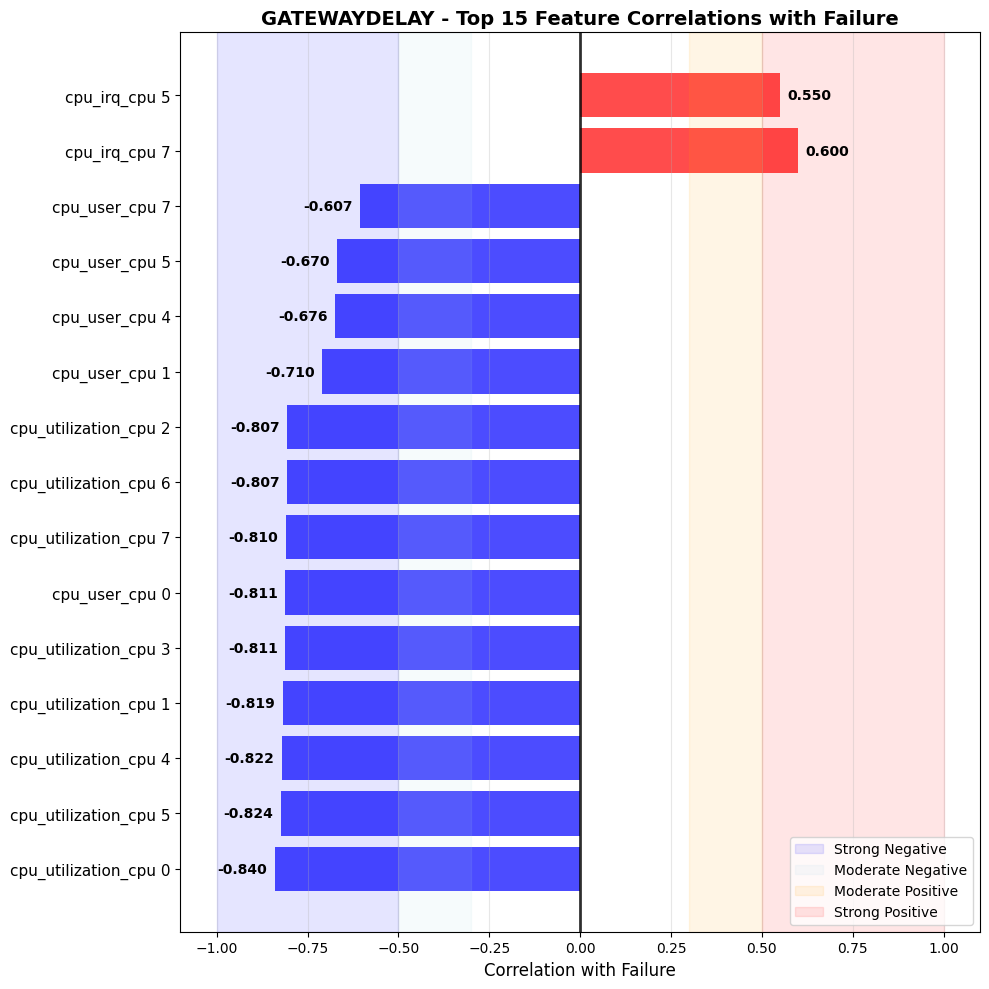

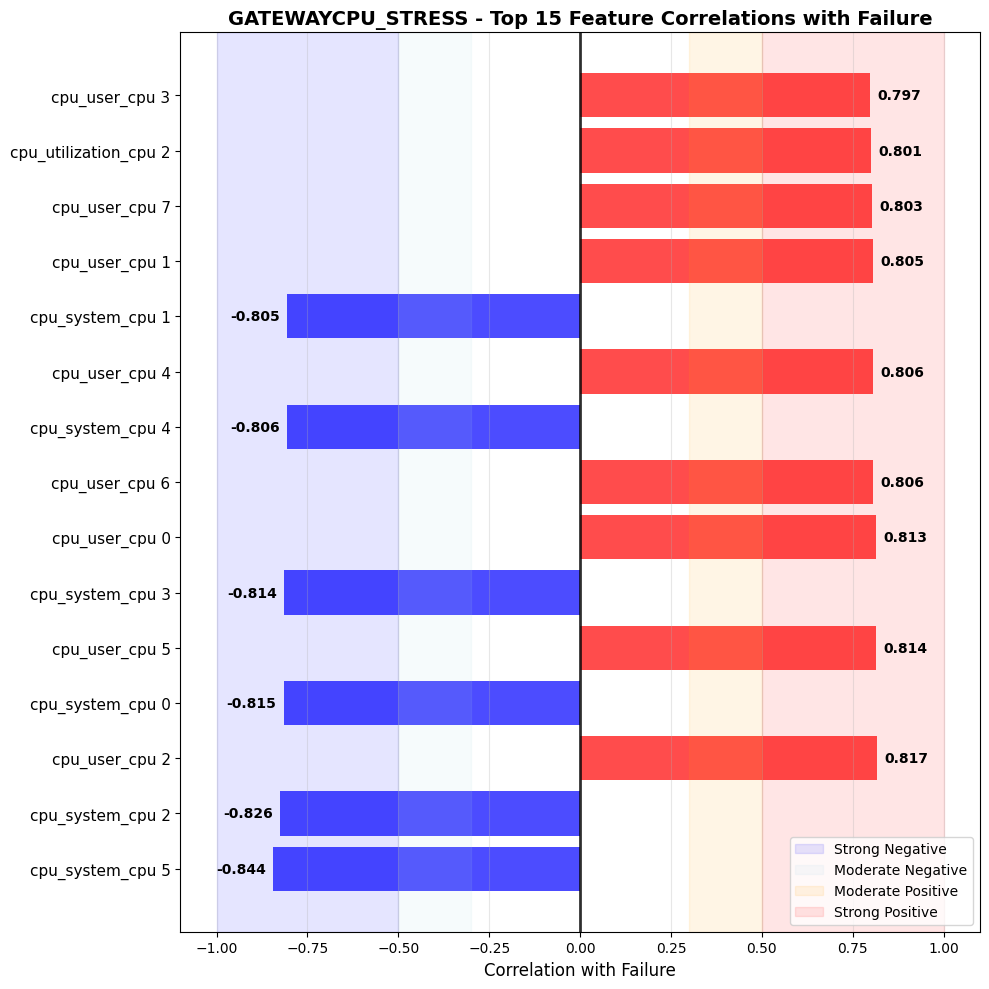

/tmp/ipykernel_100619/3885862694.py:129: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_annot = annot_matrix.applymap(lambda x: '0' if abs(x) < 1e-10 else f'{x:.3f}')


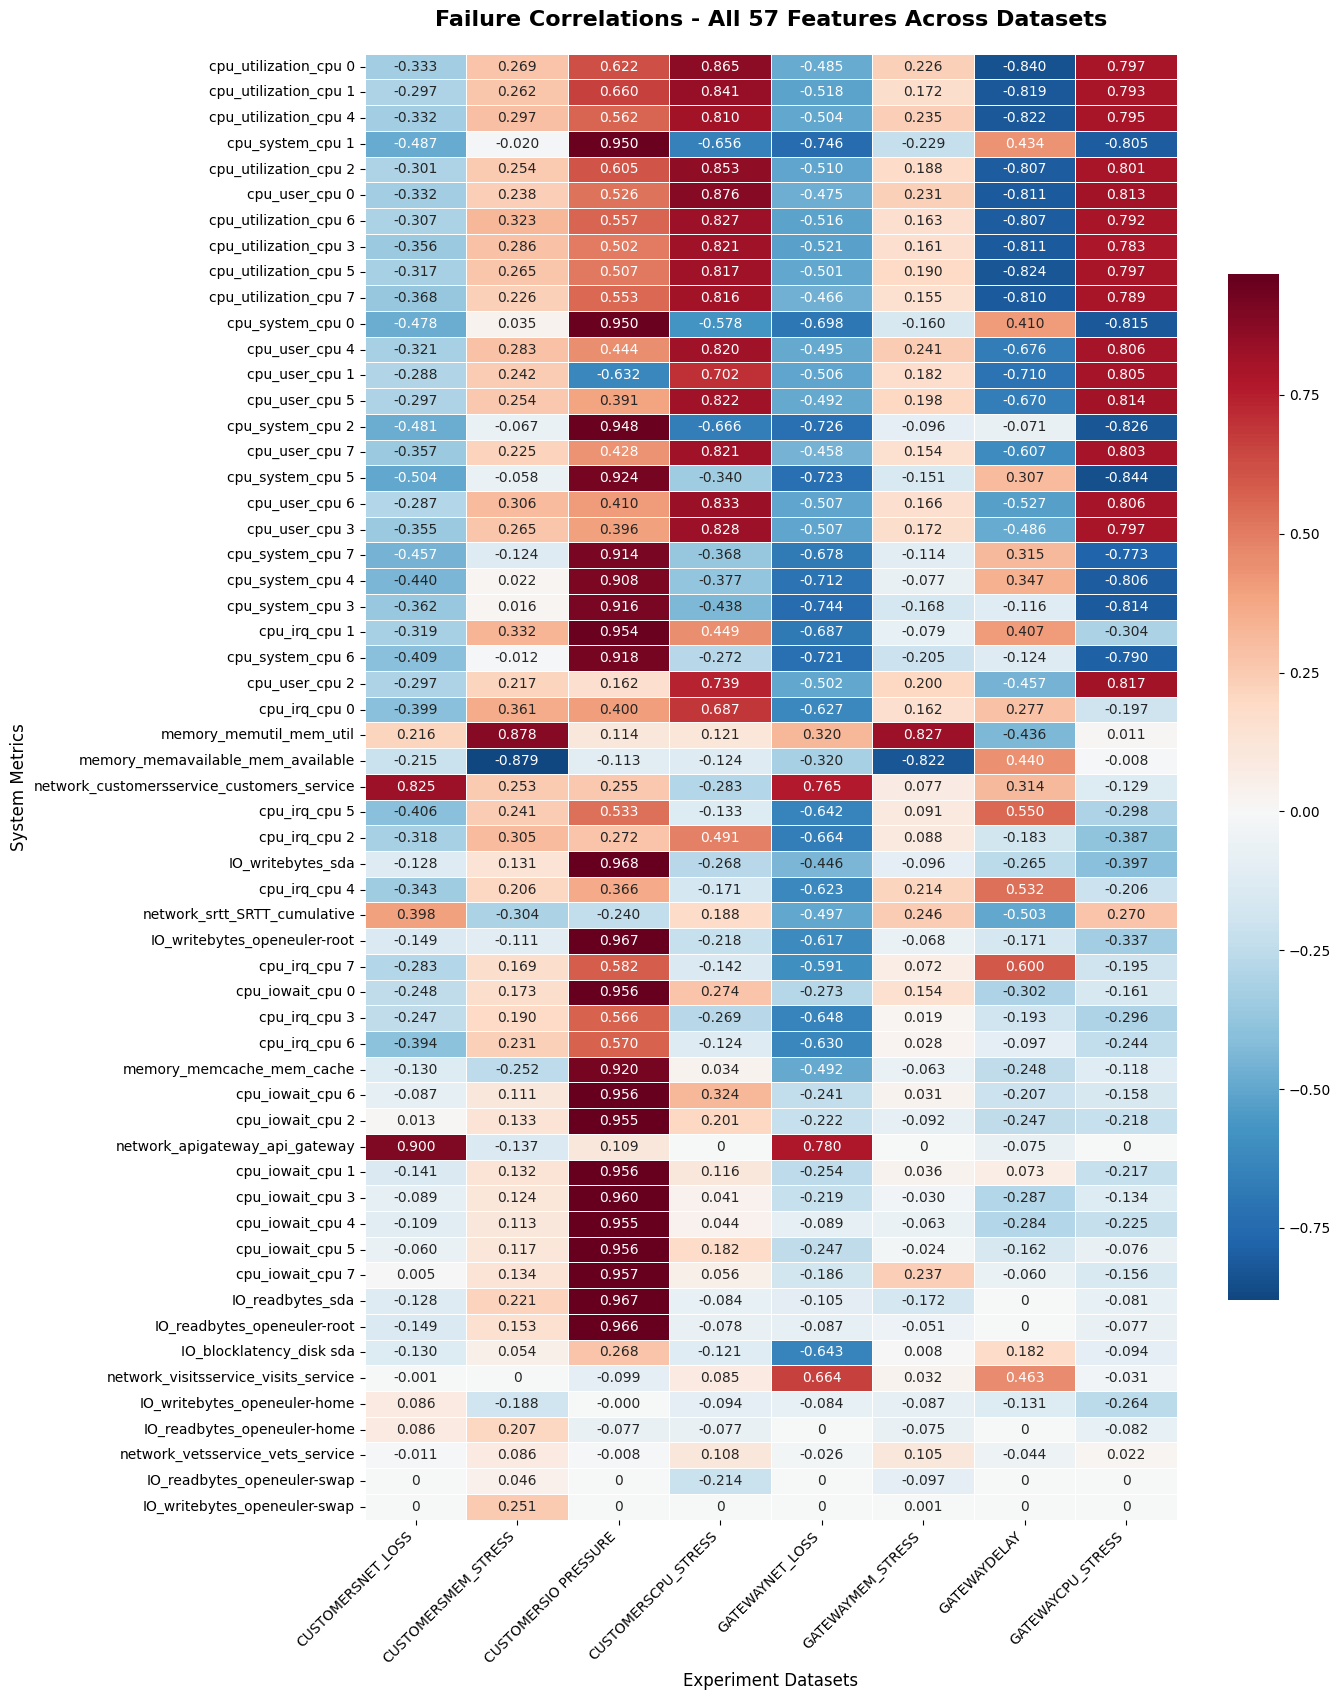

CONSTANT FEATURES IN CORRELATION ANALYSIS

CUSTOMERSNET_LOSS:
  Constant features: 2
    - IO_readbytes_openeuler-swap
    - IO_writebytes_openeuler-swap

CUSTOMERSMEM_STRESS:
  Constant features: 1
    - network_visitsservice_visits_service

CUSTOMERSIO PRESSURE:
  Constant features: 2
    - IO_readbytes_openeuler-swap
    - IO_writebytes_openeuler-swap

CUSTOMERSCPU_STRESS:
  Constant features: 2
    - IO_writebytes_openeuler-swap
    - network_apigateway_api_gateway

GATEWAYNET_LOSS:
  Constant features: 3
    - IO_readbytes_openeuler-swap
    - IO_writebytes_openeuler-swap
    - IO_readbytes_openeuler-home

GATEWAYMEM_STRESS:
  Constant features: 1
    - network_apigateway_api_gateway

GATEWAYDELAY:
  Constant features: 5
    - IO_readbytes_sda
    - IO_writebytes_openeuler-swap
    - IO_readbytes_openeuler-swap
    - IO_readbytes_openeuler-root
    - IO_readbytes_openeuler-home

GATEWAYCPU_STRESS:
  Constant features: 3
    - IO_writebytes_openeuler-swap
    - IO_readbytes_openeul

In [ ]:
def add_failure_feature(df, time_col='minutes'):
    """Add failure feature based on time window (30-80 minutes)"""
    df = df.copy()
    
    if time_col not in df.columns:
        raise ValueError(f"Time column '{time_col}' not found")
    
    df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
    df['Failure'] = 0
    df.loc[(df[time_col] >= 30) & (df[time_col] < 80), 'Failure'] = 1
    
    return df

def add_failure_to_all_datasets(all_datasets):
    """Add failure labels to all datasets permanently"""
    updated_datasets = {}
    
    for name, df in all_datasets.items():
        df_copy = df.copy()
        
        if 'baseline' in name.lower():
            df_copy['Failure'] = 0
        else:
            df_copy = add_failure_feature(df_copy)
        
        updated_datasets[name] = df_copy
    
    return updated_datasets

all_datasets = add_failure_to_all_datasets(all_datasets)

df_all_copy = df_all.copy()
df_all_copy['Failure'] = 0

# For non-baseline experiments, add failure based on time
non_baseline_mask = ~df_all_copy['source'].str.contains('BASELINE', case=False, na=False)
time_mask = (df_all_copy['minutes'] >= 30) & (df_all_copy['minutes'] < 80)
failure_mask = non_baseline_mask & time_mask

df_all_copy.loc[failure_mask, 'Failure'] = 1

# Update df_all permanently
df_all = df_all_copy

print("Failure feature added permanently to all datasets")
print(f"Individual datasets with Failure column: {[name for name in all_datasets.keys() if 'Failure' in all_datasets[name].columns]}")
print(f"df_all has Failure column: {'Failure' in df_all.columns}")
print(f"df_all failure distribution: {df_all['Failure'].value_counts().to_dict()}")

# Now run the correlation analysis with permanently added Failure column
def analyze_all_datasets_with_failure(all_datasets, target_col='Failure', top_n=15):
    all_correlations = {}
    
    for dataset_name, df in all_datasets.items():
        # No need to add Failure column - it's already there permanently
        corr_df = failure_correlations(df, target_col)
        if corr_df is not None:
            all_correlations[dataset_name] = corr_df
            plot_failure_correlations(df, target_col, top_n, dataset_name)
    
    return all_correlations

def run_failure_analysis_permanent(all_datasets):
    """Run failure analysis with permanently added Failure columns"""
    # Exclude baseline from analysis
    datasets_to_analyze = {k: v for k, v in all_datasets.items() if 'baseline' not in k.lower()}
    
    all_correlations = analyze_all_datasets_with_failure(datasets_to_analyze)
    comparison_heatmap = plot_correlation_heatmap(all_correlations, top_features=None)  
    return all_correlations, comparison_heatmap

# Run the analysis with permanent Failure columns
all_correlations, heatmap = run_failure_analysis_permanent(all_datasets)

# Analyze constant features
constant_analysis = analyze_constant_features_in_correlations(all_correlations)

## check failure target settings

In [15]:
# Display all rows of df_all with various viewing options

# Option 1: Display basic info about df_all
print("DF_ALL BASIC INFO:")
print("="*50)
print(f"Shape: {df_all.shape}")
print(f"Columns: {len(df_all.columns)}")
print(f"Memory usage: {df_all.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Option 2: Show column names
print(f"\nCOLUMNS ({len(df_all.columns)}):")
print("="*50)
for i, col in enumerate(df_all.columns):
    print(f"{i+1:2d}. {col}")

# Option 3: Set pandas display options to show more rows/columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Don't wrap columns
pd.set_option('display.max_colwidth', 50)  # Limit column width

print(f"\nFIRST 10 ROWS (showing key columns):")
print("="*50)
key_columns = ['minutes', 'source', 'service', 'Failure']
if all(col in df_all.columns for col in key_columns):
    print(df_all[key_columns].head(10))

print(f"\nSAMPLE ROWS BY EXPERIMENT:")
print("="*50)
for source in df_all['source'].unique():
    source_data = df_all[df_all['source'] == source]
    print(f"\n{source} (sample of 3 rows):")
    sample_rows = source_data.head(3)[key_columns] if len(source_data) >= 3 else source_data[key_columns]
    print(sample_rows.to_string(index=True))

# Option 4: Show all rows with failure = 1 (failures only)
print(f"\nALL FAILURE ROWS (Failure = 1):")
print("="*50)
failure_rows = df_all[df_all['Failure'] == 1]
print(f"Total failure rows: {len(failure_rows)}")
if len(failure_rows) > 0:
    print("\nFailure rows by experiment:")
    for source in failure_rows['source'].unique():
        source_failures = failure_rows[failure_rows['source'] == source]
        print(f"\n{source}: {len(source_failures)} failure rows")
        print(f"  Time range: {source_failures['minutes'].min():.1f} - {source_failures['minutes'].max():.1f}")
        print(f"  Sample times: {source_failures['minutes'].head(5).tolist()}")

# Option 5: Export to see all data
def save_df_all_to_files():
    """Save df_all to files for complete viewing"""
    # Save as CSV
    df_all.to_csv('df_all_complete.csv', index=False)
    print(f"Saved complete df_all to 'df_all_complete.csv'")
    
    # Save key info only
    key_info = df_all[['minutes', 'source', 'service', 'Failure']].copy()
    key_info.to_csv('df_all_key_info.csv', index=False)
    print(f"Saved key info to 'df_all_key_info.csv'")
    
    # Save failure analysis
    failure_analysis = []
    for source in df_all['source'].unique():
        source_data = df_all[df_all['source'] == source]
        for _, row in source_data.iterrows():
            failure_analysis.append({
                'source': row['source'],
                'service': row['service'], 
                'minutes': row['minutes'],
                'failure': row['Failure'],
                'is_baseline': 'baseline' in row['source'].lower(),
                'in_failure_window': 30 <= row['minutes'] < 80,
                'logic_check': row['Failure'] == (0 if 'baseline' in row['source'].lower() else (1 if 30 <= row['minutes'] < 80 else 0))
            })
    
    failure_df = pd.DataFrame(failure_analysis)
    failure_df.to_csv('df_all_failure_analysis.csv', index=False)
    print(f"Saved failure analysis to 'df_all_failure_analysis.csv'")

# Option 6: Interactive viewing function
def browse_df_all(start_row=0, num_rows=50):
    """Browse df_all in chunks"""
    end_row = min(start_row + num_rows, len(df_all))
    print(f"\nROWS {start_row} to {end_row-1} of {len(df_all)}:")
    print("="*50)
    
    chunk = df_all.iloc[start_row:end_row]
    key_columns = ['minutes', 'source', 'service', 'Failure']
    print(chunk[key_columns].to_string())
    
    return end_row

# Show different views
print(f"\nSHOWING DIFFERENT VIEWS OF DF_ALL:")
print("="*50)

# Browse first 20 rows
browse_df_all(0, 20)

# Show transition points (around minute 30 and 80 for stress experiments)
print(f"\nTRANSITION POINTS (around minutes 30 and 80):")
print("="*50)
transition_data = df_all[
    ((df_all['minutes'] >= 28) & (df_all['minutes'] <= 32)) |
    ((df_all['minutes'] >= 78) & (df_all['minutes'] <= 82))
]
if len(transition_data) > 0:
    print(transition_data[['minutes', 'source', 'service', 'Failure']].to_string())

# Save files for complete viewing
print(f"\nSAVING FILES FOR COMPLETE VIEWING:")
print("="*50)
save_df_all_to_files()

# Reset pandas options
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')  
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

print(f"\nTo see ALL rows, check the saved CSV files or use:")
print("df_all.to_string()  # In your environment")
print("df_all  # In Jupyter to see with scrolling")

DF_ALL BASIC INFO:
Shape: (4883, 71)
Columns: 71
Memory usage: 3.11 MB

COLUMNS (71):
 1. minutes
 2. IO_blocklatency_disk sda
 3. IO_readbytes_openeuler-home
 4. IO_readbytes_openeuler-root
 5. IO_readbytes_openeuler-swap
 6. IO_readbytes_sda
 7. IO_writebytes_openeuler-home
 8. IO_writebytes_openeuler-root
 9. IO_writebytes_openeuler-swap
10. IO_writebytes_sda
11. cpu_iowait_cpu 0
12. cpu_iowait_cpu 1
13. cpu_iowait_cpu 2
14. cpu_iowait_cpu 3
15. cpu_iowait_cpu 4
16. cpu_iowait_cpu 5
17. cpu_iowait_cpu 6
18. cpu_iowait_cpu 7
19. cpu_iowait_cpu 8
20. cpu_iowait_cpu 9
21. cpu_irq_cpu 0
22. cpu_irq_cpu 1
23. cpu_irq_cpu 2
24. cpu_irq_cpu 3
25. cpu_irq_cpu 4
26. cpu_irq_cpu 5
27. cpu_irq_cpu 6
28. cpu_irq_cpu 7
29. cpu_irq_cpu 8
30. cpu_irq_cpu 9
31. cpu_system_cpu 0
32. cpu_system_cpu 1
33. cpu_system_cpu 2
34. cpu_system_cpu 3
35. cpu_system_cpu 4
36. cpu_system_cpu 5
37. cpu_system_cpu 6
38. cpu_system_cpu 7
39. cpu_system_cpu 8
40. cpu_system_cpu 9
41. cpu_user_cpu 0
42. cpu_user_cpu

## feature engineering

In [54]:
class GeneralFeatureEngineering:
    def __init__(self, data, time_col='minutes'):
        self.data = data.copy()
        self.time_col = time_col
        self.features = data.copy()
        
        self._clean_data()
        self.features = self.features.sort_values(time_col).reset_index(drop=True)
        
        numeric_cols = self.features.select_dtypes(include=[np.number]).columns
        self.io_metrics = [col for col in numeric_cols if 'io_' in col.lower()]
        self.cpu_metrics = [col for col in numeric_cols if 'cpu_' in col.lower()]
        self.memory_metrics = [col for col in numeric_cols if 'memory_' in col.lower()]
        self.network_metrics = [col for col in numeric_cols if 'network_' in col.lower()]
    
    def _clean_data(self):
        non_numeric_cols = self.features.select_dtypes(exclude=[np.number]).columns
        
        for col in non_numeric_cols:
            if col == self.time_col:  #skip Minutes
                continue             
            
            if col == 'source':
                le = LabelEncoder()
                self.features[f'{col}_encoded'] = le.fit_transform(self.features[col].astype(str)) # encoding source for multiclass prediction
                continue
            
            if col != self.time_col:
                self.features = self.features.drop(columns=[col])  # here i'm dropping all columns != to minutes
        
        for col in self.features.columns:
            if col == self.time_col:
                continue
            if self.features[col].dtype == 'object':
                self.features[col] = pd.to_numeric(self.features[col], errors='coerce')
    
    def create_lag_features_by_group(self):
        metric_groups = {
            'cpu': {
                'columns': self.cpu_metrics,
                'lags': [1, 2, 3, 5, 10]
            },
            'memory': {
                'columns': self.memory_metrics,
                'lags': [1, 3, 5, 10]
            },
            'io': {
                'columns': self.io_metrics,
                'lags': [1, 2, 5]
            },
            'network': {
                'columns': self.network_metrics,
                'lags': [1, 3, 5]
            }
        }
        
        for group_name, config in metric_groups.items():
            existing_columns = [col for col in config['columns'] if col in self.features.columns]
            
            for col in existing_columns:
                for lag in config['lags']:
                    self.features[f"lag_{lag}_{col}"] = self.features[col].shift(lag)
        
        return self
    
    def create_rolling_features_by_group(self):
        metric_groups = {
            'cpu': {
                'columns': self.cpu_metrics,
                'windows': [5, 10, 20],
                'stats': ['mean', 'std', 'max']
            },
            'memory': {
                'columns': self.memory_metrics,
                'windows': [10, 20, 50],
                'stats': ['mean', 'std']
            },
            'io': {
                'columns': self.io_metrics,
                'windows': [3, 5, 10],
                'stats': ['mean', 'max']
            },
            'network': {
                'columns': self.network_metrics,
                'windows': [5, 10],
                'stats': ['mean', 'std']
            }
        }
        
        for group_name, config in metric_groups.items():
            existing_columns = [col for col in config['columns'] if col in self.features.columns]
            
            for col in existing_columns:
                for window in config['windows']:
                    for stat in config['stats']:
                        col_name = f"rolling_{window}_{stat}_{col}"
                        if stat == 'mean':
                            self.features[col_name] = self.features[col].rolling(window=window, min_periods=1).mean()
                        elif stat == 'std':
                            self.features[col_name] = self.features[col].rolling(window=window, min_periods=1).std()
                        elif stat == 'max':
                            self.features[col_name] = self.features[col].rolling(window=window, min_periods=1).max()
                        elif stat == 'min':
                            self.features[col_name] = self.features[col].rolling(window=window, min_periods=1).min()
        
        return self
    
    def create_diff_features_by_group(self):
        metric_groups = {
            'cpu': {
                'columns': self.cpu_metrics,
                'periods': [1, 2, 5]
            },
            'memory': {
                'columns': self.memory_metrics,
                'periods': [1, 5, 10]
            },
            'io': {
                'columns': self.io_metrics,
                'periods': [1, 3]
            },
            'network': {
                'columns': self.network_metrics,
                'periods': [1, 5]
            }
        }
        
        for group_name, config in metric_groups.items():
            existing_columns = [col for col in config['columns'] if col in self.features.columns]
            
            for col in existing_columns:
                for period in config['periods']:
                    pct_change = self.features[col].pct_change(periods=period)
                    pct_change = pct_change.replace([np.inf, -np.inf], 0).fillna(0)
                    self.features[f"pct_change_{period}_{col}"] = pct_change
        
        return self
    
    def create_aggregated_features_by_group(self):
        metric_groups = {
            'cpu': {
                'columns': self.cpu_metrics,
                'aggregations': ['mean', 'max', 'std', 'sum']
            },
            'memory': {
                'columns': self.memory_metrics,
                'aggregations': ['mean', 'max', 'min']
            },
            'io': {
                'columns': self.io_metrics,
                'aggregations': ['sum', 'max', 'mean']
            },
            'network': {
                'columns': self.network_metrics,
                'aggregations': ['sum', 'mean']
            }
        }
        
        for group_name, config in metric_groups.items():
            group_cols = [col for col in config['columns'] if col in self.features.columns]
            
            if group_cols:
                group_data = self.features[group_cols]
                
                for agg in config['aggregations']:
                    if agg == 'mean':
                        self.features[f'{group_name}_avg'] = group_data.mean(axis=1, skipna=True)
                    elif agg == 'max':
                        self.features[f'{group_name}_max'] = group_data.max(axis=1, skipna=True)
                    elif agg == 'min':
                        self.features[f'{group_name}_min'] = group_data.min(axis=1, skipna=True)
                    elif agg == 'std':
                        self.features[f'{group_name}_std'] = group_data.std(axis=1, skipna=True)
                    elif agg == 'sum':
                        self.features[f'{group_name}_total'] = group_data.sum(axis=1, skipna=True)
        
        return self
    
    def create_interaction_features_by_group(self):
        group_interactions = {
            'cpu_memory': {
                'group1': self.cpu_metrics,
                'group2': self.memory_metrics,
                'max_pairs': 5
            },
            'cpu_io': {
                'group1': self.cpu_metrics,
                'group2': self.io_metrics,
                'max_pairs': 3
            },
            'memory_io': {
                'group1': self.memory_metrics,
                'group2': self.io_metrics,
                'max_pairs': 3
            },
            'within_cpu': {
                'group1': [col for col in self.cpu_metrics if 'utilization' in col],
                'group2': [col for col in self.cpu_metrics if 'system' in col],
                'max_pairs': 5
            }
        }
        
        for interaction_name, config in group_interactions.items():
            group1_cols = [col for col in config['group1'] if col in self.features.columns]
            group2_cols = [col for col in config['group2'] if col in self.features.columns]
            
            pair_count = 0
            for col1 in group1_cols:
                for col2 in group2_cols:
                    if pair_count >= config['max_pairs']:
                        break
                    if col1 != col2:
                        self.features[f"interaction_{col1}_x_{col2}"] = self.features[col1] * self.features[col2]
                        pair_count += 1
                if pair_count >= config['max_pairs']:
                    break
        
        return self
    
    def create_statistical_features_by_group(self):
        metric_groups = {
            'cpu': {
                'columns': self.cpu_metrics,
                'windows': [10, 20],
                'stats': ['q25', 'q75', 'skew']
            },
            'memory': {
                'columns': self.memory_metrics,
                'windows': [20, 50],
                'stats': ['q25', 'q75']
            },
            'io': {
                'columns': self.io_metrics,
                'windows': [5, 10],
                'stats': ['q75']
            }
        }
        
        for group_name, config in metric_groups.items():
            existing_columns = [col for col in config['columns'] if col in self.features.columns]
            
            for col in existing_columns:
                for window in config['windows']:
                    for stat in config['stats']:
                        if stat == 'q25':
                            self.features[f"q25_{window}_{col}"] = (
                                self.features[col].rolling(window=window, min_periods=1).quantile(0.25)
                            )
                        elif stat == 'q75':
                            self.features[f"q75_{window}_{col}"] = (
                                self.features[col].rolling(window=window, min_periods=1).quantile(0.75)
                            )
                        elif stat == 'skew':
                            self.features[f"skew_{window}_{col}"] = (
                                self.features[col].rolling(window=window, min_periods=3)
                                .apply(lambda x: stats.skew(x, nan_policy='omit'), raw=True)
                            )
        
        return self
    
    def create_trend_features_by_group(self):
        metric_groups = {
            'cpu': {
                'columns': [col for col in self.cpu_metrics if 'utilization' in col],
                'windows': [10, 20]
            },
            'memory': {
                'columns': [col for col in self.memory_metrics if 'util' in col],
                'windows': [20, 50]
            },
            'io': {
                'columns': [col for col in self.io_metrics if 'bytes' in col],
                'windows': [5, 10]
            }
        }
        
        def calculate_slope(y):
            if len(y) < 2:
                return 0
            x = np.arange(len(y))
            try:
                slope, _, _, _, _ = stats.linregress(x, y)
                return slope
            except:
                return 0
        
        for group_name, config in metric_groups.items():
            existing_columns = [col for col in config['columns'] if col in self.features.columns]
            
            for col in existing_columns:
                for window in config['windows']:
                    self.features[f"trend_{window}_{col}"] = (
                        self.features[col].rolling(window=window, min_periods=2)
                        .apply(calculate_slope, raw=True)
                    )
        
        return self
    
    def create_all_features(self):
        self.create_lag_features_by_group()
        self.create_rolling_features_by_group()
        self.create_diff_features_by_group()
        self.create_aggregated_features_by_group()
        self.create_interaction_features_by_group()
        self.create_statistical_features_by_group()
        self.create_trend_features_by_group()
        
        numeric_cols = self.features.select_dtypes(include=[np.number]).columns
        self.features[numeric_cols] = self.features[numeric_cols].fillna(method='ffill').fillna(method='bfill')
        self.features[numeric_cols] = self.features[numeric_cols].fillna(0)
        self.features[numeric_cols] = self.features[numeric_cols].replace([np.inf, -np.inf], 0)
        
        return self
    
    def select_features(self, target_col, k=50):
        if target_col not in self.features.columns:
            return [], None
        
        numeric_cols = self.features.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols if col not in [target_col, self.time_col]]
        
        if len(feature_cols) == 0:
            return [], None
        
        X = self.features[feature_cols]
        y = self.features[target_col]
        
        X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
        y = y.replace([np.inf, -np.inf], np.nan).fillna(0)
        
        try:
            selector = SelectKBest(score_func=f_regression, k=min(k, len(feature_cols)))
            selector.fit(X, y)
            selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
            return selected_features, selector.scores_
        except:
            correlations = X.corrwith(y).abs().sort_values(ascending=False)
            selected_features = correlations.head(k).index.tolist()
            return selected_features, correlations.values
    
    def plot_feature_importance(self, target_col, top_n=20):
        selected_features, scores = self.select_features(target_col, k=top_n*2)
        
        if len(selected_features) == 0 or scores is None:
            return
        
        numeric_cols = self.features.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols if col not in [target_col, self.time_col]]
        
        if len(feature_cols) > 0:
            importance_df = pd.DataFrame({
                'feature': feature_cols[:len(scores)],
                'importance': scores[:len(feature_cols)]
            }).sort_values('importance', ascending=False).head(top_n)
            
            plt.figure(figsize=(12, 8))
            sns.barplot(data=importance_df, x='importance', y='feature')
            plt.title(f'Top {top_n} Features for {target_col}')
            plt.xlabel('F-score')
            plt.tight_layout()
            plt.show()

def create_forecasting_dataset(fe, target_metric, selected_features, forecast_horizon=5):
    if len(selected_features) == 0:
        return None
    
    forecast_data = fe.features.copy()
    forecast_data[f'{target_metric}_target'] = forecast_data[target_metric].shift(-forecast_horizon)
    
    feature_columns = selected_features + [fe.time_col, target_metric]
    existing_columns = [col for col in feature_columns if col in forecast_data.columns]
    
    modeling_data = forecast_data[existing_columns + [f'{target_metric}_target']].copy()
    modeling_data = modeling_data.dropna()
    
    if len(modeling_data) == 0:
        return None
    
    feature_only_cols = [col for col in existing_columns if col not in [fe.time_col, target_metric]]
    X = modeling_data[feature_only_cols]
    y = modeling_data[f'{target_metric}_target']
    time_index = modeling_data[fe.time_col]
    
    split_idx = max(1, int(len(X) * 0.8))
    
    return {
        'X_train': X.iloc[:split_idx],
        'X_val': X.iloc[split_idx:],
        'y_train': y.iloc[:split_idx],
        'y_val': y.iloc[split_idx:],
        'time_train': time_index.iloc[:split_idx],
        'time_val': time_index.iloc[split_idx:],
        'feature_names': X.columns.tolist()
    }

def find_best_target(fe):
    cpu_cols = [col for col in fe.features.columns if 'cpu_utilization' in col and 'cpu 0' in col]
    if cpu_cols:
        return cpu_cols[0]
    
    cpu_cols = [col for col in fe.features.columns if 'cpu' in col and 'utilization' in col]
    if cpu_cols:
        return cpu_cols[0]
    
    memory_cols = [col for col in fe.features.columns if 'memory' in col and 'util' in col]
    if memory_cols:
        return memory_cols[0]
    
    numeric_cols = fe.features.select_dtypes(include=[np.number]).columns
    candidates = [col for col in numeric_cols if col != fe.time_col and fe.features[col].var() > 0]
    
    return candidates[0] if candidates else None

def run_general_feature_engineering(data=None):
    if data is None:
        try:
            data = all_datasets['baseline']
        except:
            return None
    
    fe = GeneralFeatureEngineering(data, time_col='minutes')
    fe.create_all_features()
    
    target_metric = find_best_target(fe)
    if not target_metric:
        return None
    
    selected_features, _ = fe.select_features(target_metric, k=30)
    forecast_dataset = create_forecasting_dataset(fe, target_metric, selected_features)
    
    if forecast_dataset:
        fe.plot_feature_importance(target_metric, top_n=15)
        
        return {
            'fe': fe,
            'target_metric': target_metric,
            'selected_features': selected_features,
            'forecast_dataset': forecast_dataset
        }
    else:
        return None

if __name__ == "__main__":
    result = run_general_feature_engineering()

LSTM

In [ ]:

# Set working directory
os.chdir('/home/alessandro/PGFDS/results/tuna/customers')

class OptimizedFailureDetector:
    """
    Detector ottimizzato con:
    1. Soglia ottimale automatica
    2. Bilanciamento classi
    3. Focal Loss per imbalanced data
    """
    
    def __init__(self, sequence_length=20, lstm_units=64, dropout_rate=0.3, 
                 use_focal_loss=True, use_class_weights=True):
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.scaler = StandardScaler()
        self.model = None
        
        # Configurazioni ottimizzazione
        self.use_focal_loss = use_focal_loss
        self.use_class_weights = use_class_weights
        
        # Finestre adattive
        self.failure_start_percent = 0.2
        self.failure_end_percent = 0.6
        
        # Soglia ottimale (sarà calcolata automaticamente)
        self.optimal_threshold = 0.5
        
    def focal_loss(self, alpha=0.75, gamma=2.0):
        """
        FOCAL LOSS - Spiegazione dettagliata:
        
        Il problema principale è che abbiamo molti più esempi "normali" che "failure".
        Durante il training, il modello si "abitua" a predire sempre "normale" perché
        è statisticamente più probabile avere ragione.
        
        La Focal Loss risolve questo in 2 modi:
        
        1. ALPHA WEIGHTING:
           - alpha=0.75 significa che i failure (classe minority) hanno peso 3x maggiore
           - I failure "costano" di più quando sbagliati
           - Il modello è "forzato" a prestare più attenzione ai failure
        
        2. GAMMA FOCUSING:
           - gamma=2.0 riduce il peso degli esempi "facili"
           - Se il modello è già sicuro al 95%, non impara molto
           - Concentra l'apprendimento sugli esempi difficili/ambigui
        
        Matematicamente:
        FL(p_t) = -alpha * (1-p_t)^gamma * log(p_t)
        
        Dove p_t è la probabilità corretta per la classe vera.
        """
        def focal_loss_fixed(y_true, y_pred):
            # Evita log(0) che darebbe infinito
            epsilon = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
            
            # p_t = probabilità della classe corretta
            # Se y_true=1 (failure), p_t=y_pred
            # Se y_true=0 (normal), p_t=1-y_pred
            p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
            
            # Alpha weighting: più peso alla classe minority (failure)
            alpha_factor = tf.ones_like(y_true) * alpha
            alpha_t = tf.where(tf.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
            
            # Standard cross entropy
            cross_entropy = -tf.math.log(p_t)
            
            # Focusing term: (1-p_t)^gamma
            # Se p_t è alto (esempio facile), il peso è basso
            # Se p_t è basso (esempio difficile), il peso è alto
            weight = alpha_t * tf.pow((1 - p_t), gamma)
            
            # Loss finale
            loss = weight * cross_entropy
            return tf.reduce_mean(loss)
        
        return focal_loss_fixed
    
    def load_and_label_data(self, unified_dir="unified"):
        """
        Carica dati con finestra failure adattiva
        """
        all_data = []
        
        print("📊 Loading data with adaptive failure windows...")
        
        for exp_dir in os.listdir(unified_dir):
            if not os.path.isdir(os.path.join(unified_dir, exp_dir)):
                continue
                
            csv_file = os.path.join(unified_dir, exp_dir, f"all_metrics_combined_{exp_dir}.csv")
            
            if os.path.exists(csv_file):
                print(f"Loading {exp_dir}...")
                df = pd.read_csv(csv_file)
                
                # Gestione time/minutes
                if 'time' in df.columns:
                    df['minutes'] = pd.to_numeric(df['time'], errors='coerce')
                    if df['minutes'].isna().any():
                        df['minutes'] = np.arange(len(df))
                    df = df.drop(columns=['time'])
                else:
                    df['minutes'] = np.arange(len(df))
                
                duration = df['minutes'].max() - df['minutes'].min()
                
                # Labeling adattivo
                if exp_dir == 'baseline':
                    df['is_failure'] = 0
                    print(f"  Baseline: all normal")
                else:
                    failure_start = df['minutes'].min() + (duration * self.failure_start_percent)
                    failure_end = df['minutes'].min() + (duration * self.failure_end_percent)
                    
                    df['is_failure'] = ((df['minutes'] >= failure_start) & 
                                       (df['minutes'] <= failure_end)).astype(int)
                    
                    failure_count = df['is_failure'].sum()
                    print(f"  {exp_dir}: {failure_count}/{len(df)} failures ({failure_count/len(df)*100:.1f}%)")
                
                df['experiment'] = exp_dir
                all_data.append(df)
        
        return pd.concat(all_data, ignore_index=True)
    
    def prepare_features(self, df):
        """
        Prepara features escludendo colonne temporali
        """
        feature_columns = df.select_dtypes(include=[np.number]).columns
        feature_columns = [col for col in feature_columns 
                          if col not in ['minutes', 'time', 'is_failure', 'Timestamp', 'timestamp']]
        
        print(f"Using {len(feature_columns)} features")
        return df[feature_columns].fillna(0).values, feature_columns
    
    def create_sequences(self, X, y, experiments):
        """
        Crea sequenze temporali per esperimento
        """
        X_sequences = []
        y_sequences = []
        experiment_info = []
        
        for exp_name in set(experiments):
            exp_mask = experiments == exp_name
            X_exp = X[exp_mask]
            y_exp = y[exp_mask]
            
            for i in range(len(X_exp) - self.sequence_length + 1):
                sequence = X_exp[i:i + self.sequence_length]
                label = y_exp[i + self.sequence_length - 1]
                
                X_sequences.append(sequence)
                y_sequences.append(label)
                experiment_info.append(exp_name)
        
        return np.array(X_sequences), np.array(y_sequences), experiment_info
    
    def calculate_class_weights(self, y_train):
        """
        CLASS WEIGHTS - Spiegazione dettagliata:
        
        Il problema: Se hai 1000 esempi "normali" e 100 esempi "failure",
        il modello impara che "predire sempre normale" gli dà 90% accuracy.
        
        La soluzione: Dare peso maggiore alla classe minority.
        
        Calcolo automatico:
        - Se hai 90% normali e 10% failure
        - Peso normale = 1 / (2 * 0.9) = 0.56
        - Peso failure = 1 / (2 * 0.1) = 5.0
        
        Risultato: Un errore su failure "costa" 9x di più che un errore su normale.
        Il modello è incentivato a non ignorare i failure.
        """
        # Calcola pesi bilanciati automaticamente
        classes = np.unique(y_train)
        class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
        
        class_weight_dict = {}
        for i, cls in enumerate(classes):
            class_weight_dict[cls] = class_weights[i]
        
        print(f"\n⚖️  CLASS WEIGHTS CALCULATED:")
        for cls, weight in class_weight_dict.items():
            class_name = "Normal" if cls == 0 else "Failure"
            print(f"   {class_name}: {weight:.3f}")
        
        failure_weight = class_weight_dict.get(1, 1.0)
        normal_weight = class_weight_dict.get(0, 1.0)
        ratio = failure_weight / normal_weight
        
        print(f"   Failure examples are weighted {ratio:.1f}x more than normal")
        print(f"   This compensates for class imbalance")
        
        return class_weight_dict
    
    def build_optimized_model(self, input_shape):
        """
        Costruisce modello con focal loss o binary crossentropy
        """
        model = Sequential([
            LSTM(self.lstm_units, return_sequences=True, input_shape=input_shape),
            BatchNormalization(),
            Dropout(self.dropout_rate),
            
            LSTM(self.lstm_units // 2, return_sequences=False),
            BatchNormalization(),
            Dropout(self.dropout_rate),
            
            Dense(32, activation='relu'),
            Dropout(self.dropout_rate / 2),
            
            Dense(16, activation='relu'),
            
            Dense(1, activation='sigmoid')
        ])
        
        # Scelta della loss function
        if self.use_focal_loss:
            print(f"\n🎯 Using FOCAL LOSS (alpha=0.75, gamma=2.0)")
            print(f"   This will focus learning on hard examples and minority class")
            loss_function = self.focal_loss(alpha=0.75, gamma=2.0)
        else:
            print(f"\n📊 Using standard BINARY CROSSENTROPY")
            loss_function = 'binary_crossentropy'
        
        model.compile(
            optimizer='adam',
            loss=loss_function,
            metrics=['accuracy']
        )
        
        self.model = model
        return model
    
    def train_optimized_model(self, X_train, y_train, X_val, y_val, epochs=30):
        """
        Training con class weights opzionali
        """
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]
        
        # Calcola class weights se richiesto
        if self.use_class_weights:
            class_weight_dict = self.calculate_class_weights(y_train)
            print(f"\n🏋️ Training with CLASS WEIGHTS")
        else:
            class_weight_dict = None
            print(f"\n🏋️ Training WITHOUT class weights")
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=32,
            callbacks=callbacks,
            class_weight=class_weight_dict,  # Qui viene applicato il bilanciamento
            verbose=1
        )
        
        return history
    
    def find_optimal_threshold(self, X_val, y_val):
        """
        OPTIMAL THRESHOLD - Spiegazione dettagliata:
        
        Il problema: La soglia di default 0.5 è arbitraria.
        Non considera il costo relativo dei diversi tipi di errore.
        
        La soluzione: Trova la soglia che ottimizza il trade-off precision/recall.
        
        Processo:
        1. Calcola precision/recall per tutte le soglie possibili (0.0 to 1.0)
        2. Per ogni soglia, calcola F1-score = 2 * (precision * recall) / (precision + recall)
        3. Scegli la soglia che massimizza F1-score
        
        Perché F1? Bilancia precision e recall:
        - Precision alta = pochi falsi allarmi
        - Recall alto = pochi failure mancati
        - F1 alto = buon compromesso tra entrambi
        
        Alternative:
        - Se i falsi allarmi costano molto: ottimizza precision
        - Se i failure mancati costano molto: ottimizza recall
        - Per sistemi critici: spesso si preferisce recall alto
        """
        print(f"\n🔍 FINDING OPTIMAL THRESHOLD...")
        
        # Ottieni probabilità su validation set
        y_pred_proba = self.model.predict(X_val, verbose=0).flatten()
        
        # Calcola precision/recall per tutte le soglie
        precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
        
        # Calcola F1-score per ogni soglia
        # Evita divisione per zero
        f1_scores = []
        for p, r in zip(precision, recall):
            if p + r == 0:
                f1_scores.append(0)
            else:
                f1_scores.append(2 * (p * r) / (p + r))
        
        f1_scores = np.array(f1_scores)
        
        # Trova soglia ottimale
        optimal_idx = np.argmax(f1_scores)
        self.optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        optimal_f1 = f1_scores[optimal_idx]
        optimal_precision = precision[optimal_idx]
        optimal_recall = recall[optimal_idx]
        
        print(f"   Default threshold (0.5):")
        default_predictions = (y_pred_proba > 0.5).astype(int)
        default_precision = np.sum((default_predictions == 1) & (y_val == 1)) / max(np.sum(default_predictions == 1), 1)
        default_recall = np.sum((default_predictions == 1) & (y_val == 1)) / max(np.sum(y_val == 1), 1)
        default_f1 = 2 * (default_precision * default_recall) / max(default_precision + default_recall, 1e-8)
        
        print(f"     Precision: {default_precision:.3f}, Recall: {default_recall:.3f}, F1: {default_f1:.3f}")
        
        print(f"   Optimal threshold ({self.optimal_threshold:.3f}):")
        print(f"     Precision: {optimal_precision:.3f}, Recall: {optimal_recall:.3f}, F1: {optimal_f1:.3f}")
        
        improvement = ((optimal_f1 - default_f1) / default_f1 * 100) if default_f1 > 0 else 0
        print(f"   Improvement: {improvement:+.1f}% F1-score")
        
        # Plot precision-recall curve
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
        plt.plot(thresholds, recall[:-1], 'r-', label='Recall')
        plt.axvline(self.optimal_threshold, color='green', linestyle='--', label=f'Optimal ({self.optimal_threshold:.3f})')
        plt.axvline(0.5, color='orange', linestyle='--', label='Default (0.5)')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Precision/Recall vs Threshold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, 'b-')
        plt.scatter(optimal_recall, optimal_precision, color='green', s=100, 
                   label=f'Optimal (F1={optimal_f1:.3f})')
        plt.scatter(default_recall, default_precision, color='orange', s=100,
                   label=f'Default (F1={default_f1:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return self.optimal_threshold
    
    def evaluate_with_optimal_threshold(self, X_test, y_test):
        """
        Valutazione usando soglia ottimale
        """
        print(f"\n📊 EVALUATION WITH OPTIMAL THRESHOLD")
        print("="*60)
        
        # Predizioni con soglia ottimale
        y_pred_proba = self.model.predict(X_test, verbose=0).flatten()
        y_pred_optimal = (y_pred_proba > self.optimal_threshold).astype(int)
        y_pred_default = (y_pred_proba > 0.5).astype(int)
        
        # Calcola metriche per entrambe le soglie
        from sklearn.metrics import precision_score, recall_score, f1_score
        
        print(f"\n🔄 COMPARISON: Default vs Optimal Threshold")
        print("-" * 50)
        
        # Default threshold (0.5)
        acc_default = accuracy_score(y_test, y_pred_default)
        prec_default = precision_score(y_test, y_pred_default, zero_division=0)
        rec_default = recall_score(y_test, y_pred_default, zero_division=0)
        f1_default = f1_score(y_test, y_pred_default, zero_division=0)
        
        print(f"Default (0.5):     Acc={acc_default:.3f}, Prec={prec_default:.3f}, Rec={rec_default:.3f}, F1={f1_default:.3f}")
        
        # Optimal threshold
        acc_optimal = accuracy_score(y_test, y_pred_optimal)
        prec_optimal = precision_score(y_test, y_pred_optimal, zero_division=0)
        rec_optimal = recall_score(y_test, y_pred_optimal, zero_division=0)
        f1_optimal = f1_score(y_test, y_pred_optimal, zero_division=0)
        
        print(f"Optimal ({self.optimal_threshold:.3f}): Acc={acc_optimal:.3f}, Prec={prec_optimal:.3f}, Rec={rec_optimal:.3f}, F1={f1_optimal:.3f}")
        
        # Calcola miglioramenti
        print(f"\n📈 IMPROVEMENTS:")
        print(f"   Accuracy:  {acc_optimal - acc_default:+.3f}")
        print(f"   Precision: {prec_optimal - prec_default:+.3f}")
        print(f"   Recall:    {rec_optimal - rec_default:+.3f} ⭐")
        print(f"   F1-Score:  {f1_optimal - f1_default:+.3f}")
        
        # AUC
        if len(np.unique(y_test)) > 1:
            auc_score = roc_auc_score(y_test, y_pred_proba)
            print(f"   AUC:       {auc_score:.3f} (unchanged - depends on ranking)")
        
        # Confusion matrices
        cm_default = confusion_matrix(y_test, y_pred_default)
        cm_optimal = confusion_matrix(y_test, y_pred_optimal)
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Failure'],
                   yticklabels=['Normal', 'Failure'])
        plt.title('Default Threshold (0.5)')
        
        plt.subplot(1, 2, 2)
        sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Reds',
                   xticklabels=['Normal', 'Failure'],
                   yticklabels=['Normal', 'Failure'])
        plt.title(f'Optimal Threshold ({self.optimal_threshold:.3f})')
        
        plt.tight_layout()
        plt.show()
        
        return acc_optimal, prec_optimal, rec_optimal, f1_optimal

def create_failure_aware_split(X_seq, y_seq, exp_info, test_ratio=0.3):
    """
    Split che garantisce failure nel test set
    """
    train_indices = []
    test_indices = []
    
    for exp in set(exp_info):
        exp_mask = np.array(exp_info) == exp
        exp_indices = np.where(exp_mask)[0]
        exp_labels = y_seq[exp_indices]
        
        failure_indices = exp_indices[exp_labels == 1]
        normal_indices = exp_indices[exp_labels == 0]
        
        if len(failure_indices) > 0:
            # Mantieni failure in entrambi train e test
            n_failure_test = max(1, int(len(failure_indices) * test_ratio))
            failure_test = failure_indices[-n_failure_test:]
            failure_train = failure_indices[:-n_failure_test]
            
            n_normal_test = int(len(normal_indices) * test_ratio)
            normal_test = normal_indices[-n_normal_test:]
            normal_train = normal_indices[:-n_normal_test]
            
            train_indices.extend(failure_train)
            train_indices.extend(normal_train)
            test_indices.extend(failure_test)
            test_indices.extend(normal_test)
        else:
            # Solo normale (baseline)
            n_test = int(len(exp_indices) * test_ratio)
            test_indices.extend(exp_indices[-n_test:])
            train_indices.extend(exp_indices[:-n_test])
    
    return train_indices, test_indices

def main_optimized():
    """
    Training completo con tutte le ottimizzazioni
    """
    print("=== OPTIMIZED FAILURE DETECTION TRAINING ===\n")
    
    # Testa diverse configurazioni
    configurations = [
        {"name": "Baseline", "focal_loss": False, "class_weights": False},
        {"name": "Class Weights Only", "focal_loss": False, "class_weights": True},
        {"name": "Focal Loss Only", "focal_loss": True, "class_weights": False},
        {"name": "Full Optimization", "focal_loss": True, "class_weights": True},
    ]
    
    results = {}
    
    for config in configurations:
        print(f"\n{'='*80}")
        print(f"🧪 TESTING CONFIGURATION: {config['name'].upper()}")
        print(f"{'='*80}")
        
        # Inizializza detector con configurazione
        detector = OptimizedFailureDetector(
            sequence_length=20, 
            lstm_units=64,
            use_focal_loss=config['focal_loss'],
            use_class_weights=config['class_weights']
        )
        
        # Carica e prepara dati (solo una volta)
        if 'df' not in locals():
            df = detector.load_and_label_data("unified")
            X, feature_columns = detector.prepare_features(df)
            y = df['is_failure'].values
            experiments = df['experiment'].values
            
            X_scaled = detector.scaler.fit_transform(X)
            X_seq, y_seq, exp_info = detector.create_sequences(X_scaled, y, experiments)
            
            # Split
            train_idx, test_idx = create_failure_aware_split(X_seq, y_seq, exp_info)
            X_train = X_seq[train_idx]
            y_train = y_seq[train_idx]
            X_test = X_seq[test_idx]
            y_test = y_seq[test_idx]
            
            # Validation split
            val_split = int(len(X_train) * 0.8)
            X_train_final = X_train[:val_split]
            y_train_final = y_train[:val_split]
            X_val = X_train[val_split:]
            y_val = y_train[val_split:]
            
            print(f"\nDataset: {len(X_seq)} sequences, {y_seq.sum()} failures")
            print(f"Splits: Train={len(X_train_final)}, Val={len(X_val)}, Test={len(X_test)}")
        
        # Costruisci e addestra modello
        model = detector.build_optimized_model((X_seq.shape[1], X_seq.shape[2]))
        
        print(f"\n🏋️ Training {config['name']} model...")
        history = detector.train_optimized_model(
            X_train_final, y_train_final, 
            X_val, y_val, 
            epochs=25
        )
        
        # Trova soglia ottimale
        optimal_threshold = detector.find_optimal_threshold(X_val, y_val)
        
        # Valuta con soglia ottimale
        acc, prec, rec, f1 = detector.evaluate_with_optimal_threshold(X_test, y_test)
        
        # Salva risultati
        results[config['name']] = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'threshold': optimal_threshold
        }
        
        # Salva modello
        model_name = f"optimized_detector_{config['name'].lower().replace(' ', '_')}.keras"
        detector.model.save(model_name)
        print(f"✅ Saved: {model_name}")
    
    # Confronto finale
    print(f"\n{'='*80}")
    print(f"🏆 FINAL COMPARISON OF ALL CONFIGURATIONS")
    print(f"{'='*80}")
    
    comparison_df = pd.DataFrame(results).T
    print(comparison_df.round(3))
    
    # Trova migliore configurazione
    best_config = comparison_df['f1'].idxmax()
    best_f1 = comparison_df['f1'].max()
    
    print(f"\n🥇 BEST CONFIGURATION: {best_config}")
    print(f"   F1-Score: {best_f1:.3f}")
    print(f"   Recall: {comparison_df.loc[best_config, 'recall']:.3f}")
    print(f"   Precision: {comparison_df.loc[best_config, 'precision']:.3f}")
    
    return results, detector

# Esegui training ottimizzato
print("Starting optimized training with all techniques...")
results, best_detector = main_optimized()